In [1]:
import os
import sys
p = '..'
while not os.path.isdir(p + '/notebooks'):
    p += '/..'
sys.path.append(p) # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib
import joblib

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv2,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
)
from src.data_fetcher import DataFetcher
cloudpickle.register_pickle_by_value(src) # for model portability

os.environ["USE_JOBLIB_MEMORY"] = "1"

def get_joblib_memory():
    if os.getenv('USE_JOBLIB_MEMORY'):
        return joblib.Memory('/tmp/alphapool_joblib_memory', verbose=0)
    else:
        return joblib.Memory(None, verbose=0)

model_name = '20221018_btc_one_cnn'

In [2]:
# symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
# symbols += 'DOGE,SFP,DYDX,AXS,CHZ,TRX,MASK,ETC,LTC,1000SHIB,C98,SAND,SUSHI,NEAR,FIL'.split(',')
# symbols += 'SFP,DYDX,AXS,TRX,MASK,ETC,LTC,1000SHIB,C98,SAND,SUSHI,NEAR,FIL'.split(',')
symbols = ['ADA', 'ATOM', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP', 'ETC', 'LTC'] # binance, bybit, okex
# symbols = ['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP', 'ETC', 'LTC'] # binance, bybit
# symbols = ['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP'] # binance, bybit

provider_configs = [
    {
        'provider': 'bigquery',
        'options': {
            'table': 'binance_ohlcv',
            'symbols': ['{}USDT'.format(x) for x in symbols],
        }
    },
]

dfs = DataFetcher(memory=get_joblib_memory()).fetch(
    provider_configs=provider_configs, 
    min_timestamp=None,
)

for df in dfs:
    display(df)

def merge_data(dfs):
    df = dfs[0]
    df['symbol'] = df['symbol'].str.replace('USDT', '')
    df = df.set_index(['timestamp', 'symbol']).sort_index()
    return df

df = merge_data(dfs)

def merge_kraken_data(df):
    symbols = list(df.index.get_level_values('symbol').unique())
    
    train_provider_configs = [
        {
            'provider': 'bigquery',
            'options': {
                'table': 'kraken_historical_ohlcvt',
                'symbols': symbols,
            }
        },
    ]

    dfs = DataFetcher(memory=get_joblib_memory()).fetch(
        provider_configs=train_provider_configs, 
        min_timestamp=None,
    )
    df_kraken = dfs[0].set_index(['timestamp', 'symbol'])

    df = df.copy()
    df['extended'] = False
    df = pd.concat([df, df_kraken])
    df['extended'] = df['extended'].fillna(True)
    df = df[['op', 'hi', 'lo', 'cl', 'volume', 'twap_5m', 'extended']]
    df = df.loc[~df.index.duplicated()]
    df = df.sort_index()
    return df.copy()

df = merge_kraken_data(df)

df = df.dropna()
df.to_pickle('/tmp/df_binance_ohlcv_extended.pkl')
display(df)

,timestamp,symbol,op,hi,lo,cl,volume,amount,trades,buy_volume,...,twap,twap_5m,cl_std,cl_diff_std,hi_twap,lo_twap,hi_op_max,lo_op_min,ln_hi_lo_mean,ln_hi_lo_sqr_mean
0,2022-07-08 21:00:00+00:00,ADAUSDT,0.4701,0.4731,0.4671,0.4674,23271114.0,1.095514e+07,19177.0,11731510.0,...,0.470872,0.470775,0.001503,0.000543,0.471177,0.470570,0.000258,-0.000348,0.001289,0.000002
1,2022-07-20 19:00:00+00:00,ADAUSDT,0.5089,0.5128,0.5032,0.5052,34962395.0,1.774341e+07,30250.0,17279381.0,...,0.507722,0.507642,0.002051,0.000584,0.508148,0.507293,0.000373,-0.000482,0.001684,0.000003
2,2022-07-24 12:00:00+00:00,ADAUSDT,0.5262,0.5305,0.5223,0.5237,52979601.0,2.788418e+07,41357.0,25678072.0,...,0.526623,0.526425,0.001789,0.000774,0.527147,0.526110,0.000488,-0.000548,0.001969,0.000005
3,2022-07-27 00:00:00+00:00,ADAUSDT,0.4674,0.4687,0.4634,0.4652,31111279.0,1.448926e+07,24080.0,13589855.0,...,0.465348,0.465267,0.001267,0.000596,0.465782,0.464945,0.000402,-0.000435,0.001797,0.000004
4,2022-07-15 20:00:00+00:00,ADAUSDT,0.4475,0.4537,0.4432,0.4453,54673926.0,2.448470e+07,42036.0,28570664.0,...,0.446385,0.446367,0.001678,0.000854,0.446965,0.445958,0.000555,-0.000452,0.002252,0.000008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241815,2021-11-17 07:00:00+00:00,MATICUSDT,1.5215,1.5489,1.5073,1.5328,7928678.0,1.212844e+07,21684.0,3830067.0,...,1.524733,1.524658,0.012387,0.002233,1.526488,1.523025,0.001885,-0.001578,0.002269,0.000006
241816,2021-11-15 09:00:00+00:00,MATICUSDT,1.7442,1.7690,1.7386,1.7578,12044402.0,2.114491e+07,36394.0,5680896.0,...,1.754850,1.755817,0.007133,0.002226,1.756210,1.753075,0.001610,-0.001525,0.001786,0.000004
241817,2021-10-31 03:00:00+00:00,MATICUSDT,1.9113,1.9494,1.8949,1.9487,9549132.0,1.833721e+07,52414.0,4815594.0,...,1.914738,1.915192,0.013883,0.003910,1.917207,1.911813,0.003145,-0.002248,0.002813,0.000010
241818,2021-11-03 00:00:00+00:00,MATICUSDT,1.9416,1.9927,1.9399,1.9734,19082415.0,3.749070e+07,69466.0,9379611.0,...,1.959675,1.961183,0.015315,0.003893,1.962325,1.956372,0.003192,-0.002762,0.003036,0.000010


op          hi         lo  \
timestamp                 symbol                                      
2013-10-06 21:00:00+00:00 BTC      122.00000   122.00000   122.0000   
2013-10-07 20:00:00+00:00 BTC      123.61000   123.61000   123.6100   
2013-10-08 02:00:00+00:00 BTC      123.91000   123.91000   123.9000   
2013-10-08 05:00:00+00:00 BTC      124.19000   124.19000   124.1800   
2013-10-09 09:00:00+00:00 BTC      124.01687   124.01687   123.8400   
...                                      ...         ...        ...   
2022-11-22 22:00:00+00:00 ETH     1130.44000  1140.00000  1125.3700   
                          LINK       6.34900     6.38700     6.2970   
                          LTC       69.08000    70.58000    69.0800   
                          MATIC      0.83990     0.85500     0.8383   
                          XRP        0.37670     0.37840     0.3754   

                                         cl        volume      twap_5m  \
timestamp                 symbol                                         
2013-10-06 21:00:00+00:00 BTC      122.0000  1.000000e-01   122.000000   
2013-10-07 20:00:00+00:00 BTC      123.6100  1.000000e-01   123.610000   
2013-10-08 02:00:00+00:00 BTC      123.9000  1.991600e+00   123.900000   
2013-10-08 05:00:00+00:00 BTC      124.1800  2.000000e+00   124.180000   
2013-10-09 09:00:00+00:00 BTC      123.8400  2.823000e+00   123.840000   
...                                     ...           ...          ...   
2022-11-22 22:00:00+00:00 ETH     1137.0000  1.432570e+05  1130.668333   
                          LINK       6.3530  2.638726e+06     6.336667   
                          LTC       69.6900  5.037114e+05    69.469167   
                          MATIC      0.8476  2.497548e+07     0.843900   
                          XRP        0.3778  3.694761e+07     0.376608   

                                  extended  
timestamp                 symbol            
2013-10-06 21:00:00+00:00 BTC         True  
2013-10-07 20:00:00+00:00 BTC         True  
2013-10-08 02:00:00+00:00 BTC         True  
2013-10-08 05:00:00+00:00 BTC         True  
2013-10-09 09:00:00+00:00 BTC         True  
...                                    ...  
2022-11-22 22:00:00+00:00 ETH        False  
                          LINK       False  
                          LTC        False  
                          MATIC      False  
                          XRP        False  

[421155 rows x 7 columns]

In [3]:
# based on 20220910_eda

import numba
from pandas.api.types import is_float_dtype

def signed_rsi_sma(x, timeperiod=14):
    v = x.diff(1).fillna(0)
    return (v.rolling(timeperiod, 1).sum() / (1e-37 + v.abs().rolling(timeperiod, 1).sum())).clip(-1, 1)

def uniform_rank(x):
    return unbiased_rank(x)
    # count = x.transform("count")
    # rank = x.rank()
    # return (rank - 0.5) / count

def beta_mean(df, col):
    # broadcast btc value
    idx = df.index.to_frame()
    idx['symbol'] = 'BTC'
    idx = pd.MultiIndex.from_frame(idx)
    return pd.Series(df.loc[idx, col].values, index=df.index)
    
def calc_features(df, with_ret=False):
    mem = get_joblib_memory()
    return mem.cache(do_calc_features)(df, with_ret=with_ret)
    
def do_calc_features(df, with_ret=False):
    dfs = []
    for symbol, df_symbol in df.groupby('symbol'):
        dfs.append(calc_features_single(df_symbol))
    df = pd.concat(dfs).sort_index()

    beta_window = 24 * 30
    # beta_window = 24 * 7

    # df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
    df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
    
    # wrong
    # df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(beta_window, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)

    # df['beta'] = (
    #     (df['ln_cl_diff'] * df['ln_cl_diff_mean']).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    #     / (df['ln_cl_diff_mean'] ** 2).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    # ).fillna(0).clip(0.1, 2.0)
    df['beta'] = 1.0
    
    dfs = [
        df,
        # df.drop(columns=get_feature_columns(df)),
    ]
    
    if with_ret:
        ret_mean = beta_mean(df, 'ret')
        dfs += [
            (uniform_rank(df.groupby('timestamp')['ret']) - 0.5).rename('ret_rank'),
            (df['ret'] - df['beta'] * ret_mean).rename('ret_beta'),
        ]
    
    for col in get_feature_columns(df):
        feature_mean = beta_mean(df, col)
        dfs += [
            # (2 * uniform_rank(df.groupby('timestamp')[col]) - 1).rename(col + '_symbolrank'),
            (df[col] - df['beta'] * feature_mean).rename(col + '_symbolbeta'),
        ]
    df = pd.concat(dfs, axis=1)
    
    # dfs = [df]
    # for col in get_feature_columns(df):
    #     if '_symbolbeta' not in col:
    #         continue
    #     dfs += [
    #         (2 * uniform_rank(df.groupby('timestamp')[col]) - 1).rename(col.replace('symbolbeta', 'symbolbtrk')),
    #     ]
    # df = pd.concat(dfs, axis=1)
    
    df = df[sorted([x for x in df.columns if is_float_dtype(df.dtypes[x])])].copy().astype('float32')

    return df

def calc_features_single(df):
    df = df.copy()

    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    df['ln_cl'] = np.log(df['cl'])
    df['ln_hi'] = np.log(df['hi'])
    df['ln_lo'] = np.log(df['lo'])
    df['ln_hilo'] = 0.5 * (df['ln_hi'] + df['ln_lo'])
    df['ln_cl_diff'] = df['ln_cl'].diff(1).fillna(0)
    df['ln_volume'] = np.log1p(df['volume'])

    dfs = [df]
    
    # for i in range(1, 96):
    # for i in range(1, 96 // 4):
    for i in range(1, 96 // 8):
    # for i in range(1, 192 // 8):
        dfs += [
            # (df['ln_cl'] - df['ln_cl'].rolling(8 * i).mean()).fillna(0).rename('feature_{:02}_ln_cl_kairi'.format(i)), # good
            # df['ln_cl'].diff(8).shift(i * 8).fillna(0).rename('feature_ln_cl_diff_{:02}'.format(i)),
            df['ln_cl'].diff(8 * i).fillna(0).rename('feature_{:02}_ln_cl_diff'.format(i)), # good
            # df['ln_cl'].diff(1 * i).fillna(0).rename('feature_{:02}_ln_cl_diff'.format(i)),
            # df['ln_cl'].diff(4 * i).fillna(0).rename('feature_{:02}_ln_cl_diff'.format(i)),
            # df['ln_cl'].rolling(8 * i).std().fillna(0).rename('feature_{:02}_ln_cl_std'.format(i)),
            # df['ln_volume'].diff(8 * i).fillna(0).rename('feature_{:02}_ln_volume_diff'.format(i)),
            # df['ln_volume'].rolling(8 * i).mean().fillna(0).rename('feature_{:02}_ln_volume_mean'.format(i)),
            # np.log1p(df['volume'].rolling(8 * i).mean()).fillna(0).rename('feature_{:02}_ln_volume_mean2'.format(i)),
            # signed_rsi_sma(df['cl'], timeperiod=i).fillna(0).rename('feature_{:02}_rsi'.format(i)),
        ]

    return pd.concat(dfs, axis=1)

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Reshape, Conv1D, Conv2D, Conv3D, Flatten, MaxPooling1D, AveragePooling1D,
    BatchNormalization, Concatenate, Activation, Rescaling, Add, Subtract, Lambda,
    GlobalMaxPooling1D, GlobalAveragePooling1D
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam, SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from scipy.stats import norm
from scikeras.wrappers import KerasRegressor
from functools import partial
import tensorflow_addons as tfa

2022-11-22 23:08:48.526995: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-22 23:08:48.707156: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-22 23:08:48.707216: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-22 23:08:48.739187: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-22 23:08:49.604757: W tensorflow/stream_executor/platform/de

In [5]:
from tensorflow.python.ops import gen_math_ops, nn_ops

class GaussianDropConnectDense(Dense):
    def build(self, input_shape):
        super().build(input_shape)
        
        self.kernel_initial = self.kernel.numpy()
        # print(self.kernel_initial)
        
#         self.kernel_old = self.kernel
#         self.bias_old = self.bias
        
        
        
#         self.kernel = self.kernel_old
#         self.bias = self.bias_old * tf.keras.backend.random_normal(
#             shape=tf.shape(self.bias_old),
#             mean=1.0,
#             stddev=sigma,
#             dtype=self.bias_old.dtype,
#             seed=None
#         )
    
    def call(self, inputs, training=None):     
        # dropout_rate = 0.3   
        dropout_rate = 0.5      
        # dropout_rate = 0.7
        sigma = np.sqrt(dropout_rate / (1.0 - dropout_rate))
        
        # kernel = self.kernel_initial + tf.keras.backend.dropout(self.kernel - self.kernel_initial, dropout_rate, seed=None) / (1.0 - dropout_rate)
        kernel = self.kernel_initial + (self.kernel - self.kernel_initial) * tf.keras.backend.random_normal(
            shape=tf.shape(self.kernel),
            mean=1.0,
            stddev=sigma,
            dtype=self.kernel.dtype,
            seed=None
        )
        bias = self.bias
        
        # kernel = self.kernel * tf.keras.backend.random_normal(
        #     shape=tf.shape(self.kernel),
        #     mean=1.0,
        #     stddev=sigma,
        #     dtype=self.kernel.dtype,
        #     seed=None
        # )
        # bias = self.bias * tf.keras.backend.random_normal(
        #     shape=tf.shape(self.bias),
        #     mean=1.0,
        #     stddev=sigma,
        #     dtype=self.bias.dtype,
        #     seed=None
        # )
        
        kernel = tf.keras.backend.in_train_phase(kernel, self.kernel, training=training)
        bias = tf.keras.backend.in_train_phase(bias, self.bias, training=training)
        
        if inputs.dtype.base_dtype != self._compute_dtype_object.base_dtype:
          inputs = math_ops.cast(inputs, dtype=self._compute_dtype_object)

        rank = inputs.shape.rank
        if rank == 2 or rank is None:
            outputs = gen_math_ops.MatMul(a=inputs, b=kernel)
        # Broadcast kernel to inputs.
        else:
          outputs = standard_ops.tensordot(inputs, kernel, [[rank - 1], [0]])
          # Reshape the output back to the original ndim of the input.
          if not context.executing_eagerly():
            shape = inputs.shape.as_list()
            output_shape = shape[:-1] + [kernel.shape[-1]]
            outputs.set_shape(output_shape)

        if self.use_bias:
          outputs = nn_ops.bias_add(outputs, bias)

        if self.activation is not None:
          outputs = self.activation(outputs)
        return outputs

In [6]:
class WeightLenCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.initial_weights = self.model.get_weights()
        self.initial_weights_norm = self._calc_dist(self.initial_weights)
        self.prev_weights = self.initial_weights
        self.weight_len = 0.0

    def on_epoch_end(self, epoch, logs=None):
        weights = self.model.get_weights()
        weight_dist = self._calc_dist(self.initial_weights, weights)
        weight_dist2 = self._calc_dist(self.initial_weights, weights, True)
        logs['weight_dist'] = weight_dist
        # logs['weight_dist2'] = weight_dist2
        logs['weight_len'] = self.weight_len
        logs['weight_ndist'] = weight_dist / self.initial_weights_norm
        logs['weight_nlen'] = self.weight_len / self.initial_weights_norm

    def on_train_batch_end(self, batch, logs=None):
        weights = self.model.get_weights()
        self.weight_len += self._calc_dist(self.prev_weights, weights)
        self.prev_weights = weights
        
    def _calc_dist(self, w1, w2=None, normalized=False):
        d = 0.0
        for i in range(len(w1)):
            x = w1[i]
            y = w1[i] if w2 is None else w2[i] 
            if normalized:
                x = x / (1e-37 + np.sum(x ** 2) ** 0.5)
                y = y / (1e-37 + np.sum(y ** 2) ** 0.5)
            if w2 is None:
                d += np.sum(x ** 2)
            else:
                d += np.sum((x - y) ** 2)
        return d ** 0.5

In [7]:
# support multi dimension
class MyVotingRegressor:
    def __init__(self, models):
        self._models = models
        
    def fit(self, X, y, sample_weight=None):
        for label, m in self._models:
            m.fit(X, y, sample_weight=sample_weight)
        return self
        
    def predict(self, X):
        ys = []
        for label, m in self._models:
            ys.append(m.predict(X))
        return np.mean(ys, axis=0)

In [8]:
class LambdaTrain(Lambda):    
    def call(self, inputs, training=None):     
        return tf.keras.backend.in_train_phase(super().call(inputs), inputs, training=training)

In [9]:
import tempfile

class SimpleKerasPredictor:
    def __init__(self, model):
        # self.model = model
        
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        self.tflite_data = converter.convert()
        
    def predict(self, X):
        if True:
            interpreter = tf.lite.Interpreter(model_content=self.tflite_data)
            signatures = interpreter.get_signature_list()
            # print(signatures)

            input_name = signatures['serving_default']['inputs'][0]
            output_name = signatures['serving_default']['outputs'][0]
            # {'serving_default': {'inputs': ['input_14'], 'outputs': ['activation_13']}}

            sig = interpreter.get_signature_runner()
            # print(sig)
            return sig(**{ input_name: X })[output_name]
        else:
            return self.model.predict(X)
    
    def __getstate__(self):
        state = {}
        state['tflite_data'] = self.tflite_data
        # with tempfile.TemporaryDirectory() as dir:
        #     filename = dir + '/model.h5'
        #     self.model.save(filename, include_optimizer=False)
        #     with open(filename, 'rb') as f:
        #         state['model'] = f.read()
        return state
        
    def __setstate__(self, state):
        self.tflite_data = state['tflite_data']
        # interpreter = tf.lite.Interpreter(model_content=self.tflite_data)
        # self.sig = interpreter.get_signature_runner()

        # with tempfile.TemporaryDirectory() as dir:
        #     model_data = state.get('model')
        #     filename = dir + '/model.h5'
        #     with open(filename, 'wb') as f:
        #         f.write(model_data)
        #     self.model = tf.keras.models.load_model(filename)    

In [10]:

from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor, VotingRegressor

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cluster import FeatureAgglomeration
import xgboost as xgb
from sklearn.ensemble import HistGradientBoostingRegressor, BaggingRegressor
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from sklearn.linear_model import RidgeCV

class ExampleModelRank:
    def __init__(self, ensemble=10):
        # self._model = Ridge(fit_intercept=False, alpha=1e20)
        # self._model = Pipeline([
        #     ('ss', StandardScaler()),
        #     ('model', self._model)
        # ])
        
        # self._model = lgb.LGBMRegressor(
        #     n_estimators=1000,
        #     learning_rate=0.01,
        #     extra_trees=True,
        #     # colsample_bytree=0.9,
        #     colsample_bytree=0.03,
        #     # lambda_l2=1e1,
        #     random_state=1,
        #     n_jobs=-1,
        # )
        
        # self._model = lgb.LGBMClassifier(
        #     # n_estimators=1000,
        #     # learning_rate=0.001,
        #     random_state=1,
        #     n_jobs=-1,
        # )
        
        
        # union = FeatureUnion([
        #     ("pt", 'passthrough'),
        #     ("pca", PCA(n_components=32)),
        #     ("svd", TruncatedSVD(n_components=32)),
        #     ("agg", FeatureAgglomeration(n_clusters=32)),
        # ])
        # self._model = Pipeline([
        #     # ('feat_agglo', FeatureAgglomeration(n_clusters=64)),
        #     ('union', union),
        #     ('model', self._model)
        # ])
        
        
        self.max_data_sec = 2 * 30 * 24 * 60 * 60 # for predict script
        self.provider_configs = provider_configs
        self.merge_data = merge_data
        
        self.ensemble = ensemble

    def fit(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        
        df['ret_train'] = df['ret']
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-24) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-4) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df['ln_hilo']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilocl'].shift(-24) - df['ln_hilocl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df.groupby('symbol')['ln_hilo'].shift(12)).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-48) - df['ln_hilo']).fillna(0)
        # def calc_ret(x):
        #     hi = df.loc[x.index, 'hi']
        #     lo = df.loc[x.index, 'lo']
        #     return 0.5 * (hi.rolling(24, 1).max().shift(-24) + lo.rolling(24, 1).min().shift(-24)) / x - 1
        # df['ret_train'] = df.groupby('symbol')['cl'].transform(calc_ret)
        
        # df['ret_rank'] = unbiased_rank(df.groupby('timestamp')['ret_train']) - 0.5
        # df['ret_mean'] = df.groupby('timestamp')['ret_train'].transform('mean')
        df['ret_mean'] = beta_mean(df, 'ret_train')
        df['ret_beta'] = df['ret_train'] - df['ret_mean'] * df['beta']
        df = df.dropna()
        self.symbols = get_symbols(df) # for predict script
        
        df = df.loc[df.index.get_level_values('symbol') != 'BTC']
        
        print('fit df.shape', df.shape)
        
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=5,
            # verbose=0,
            # mode="auto",
            # min_delta=0.0001,
            # cooldown=0,
            # min_lr=0,
        )
        
        es = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            # monitor='val_mse_weighted',
            min_delta=0,
            # patience=10,
            patience=40,
            verbose=0,
            mode='auto',
            # mode='max',
            baseline=None,
            restore_best_weights=True
        )
        
        tb = tf.keras.callbacks.TensorBoard(
            log_dir="tb_logs",
            histogram_freq=1,
            write_graph=True,
            write_images=False,
            write_steps_per_second=False,
            update_freq="epoch",
            profile_batch=0,
            embeddings_freq=1,
            embeddings_metadata=None,
        )

        # lr1 = 0.002
        lr1 = 0.002 * 1e-1
        lr0 = lr1 * 1e-2
        def scheduler(epoch, lr):
            if epoch <= 10:
                t = epoch / 10.0
            else:
                t = 1.0
            return np.exp(np.log(lr0) * (1 - t) + np.log(lr1) * t)
        
        # self._model = KerasRegressor(
        #     model=partial(build_keras_model, len(features) * 2 + 20 + 20 - 100 * 0, 0),
        #     # model=partial(build_keras_model, len(features) * 1, 0),
        #     random_state=1,
        #     # random_state=np.random.RandomState(1),
        #     # epochs=1,
        #     # epochs=4,
        #     # epochs=20,
        #     epochs=1000,
        #     validation_split=0.3, # worse than not using val
        #     callbacks=[
        #         es,
        #         # reduce_lr,
        #         # tf.keras.callbacks.LearningRateScheduler(scheduler),
        #         WeightLenCallback(),
        #         # WeightShuffleCallback(),
        #         tb, # last
        #     ],
        #     # batch_size=4096 // 8 // 8,
        #     # batch_size=4096 // 8,
        #     batch_size=4096,
        #     # batch_size=65536,
        #     # batch_size=df.shape[0],
        #     # shuffle=False,
        #     verbose=2,
        #     warm_start=True,
        # )
        # keras_model = self._model
        
        models = []
        for i in range(0, self.ensemble):
            models.append(['nn{}'.format(i), KerasRegressor(
                # model=partial(build_keras_model, len(features) * 2 + 20 + 20 - 100 * 0, i),
                model=partial(build_keras_model, len(features) * 1, i),
                epochs=1000,
                validation_split=0.3, # worse than not using val
                callbacks=[
                    es,
                    # WeightLenCallback(),
                    tb, # last
                ],
                # batch_size=4096 * 8,
                batch_size=4096,
                # batch_size=4096 // 8,
                random_state=i,
                verbose=2 if self.ensemble <= 10 else 0,
            )])
        self._model = MyVotingRegressor(models)
        
        # self._model = BaggingRegressor(self._model, random_state=1)

        nonstationary_est = lgb.LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            extra_trees=True,
            colsample_bytree=0.03,
            random_state=1,
            n_jobs=-1,
        )
        
        def scale_func(x):
            return x * 0.1
        
        qt_n = 100
        
        self._model = Pipeline([
            # ('qt', QuantileTransformer(n_quantiles=qt_n, output_distribution='normal', random_state=1)),
            # ('qt', QuantileTransformer(output_distribution='uniform', random_state=1)),
            # ('sc', StandardScaler(with_mean=False)),
            ('sc', StandardScaler()),
            # ('fu', FeatureUnion([ # not good?
            #     ('pt', 'passthrough'),
            #     ('qt', QuantileTransformer(n_quantiles=qt_n, output_distribution='normal', random_state=1)),
            #     ('pca', PCA(20, whiten=True)), # good?
            #     # ('fa', FeatureAgglomeration(20, pooling_func=np.median)), # not good?
            #     ('fa_std', Pipeline([ # not bad?
            #         ('fa_std2', FeatureAgglomeration(20, pooling_func=np.std)),
            #         ('qt2', QuantileTransformer(n_quantiles=qt_n, output_distribution='normal', random_state=1)),
            #     ])),
            # ])),
            # ('scale', FunctionTransformer(scale_func)),
            # ('pca', PCA(whiten=True)), # bad
            ('model', self._model)
        ])
        
        # self._model = Ridge(alpha=1e5, fit_intercept=False)
        # self._model = RidgeCV(fit_intercept=False)
        
        # dfs = []
        # for i in range(4):
        #     df2 = df.copy()
        #     df2[features] = df2[features] + np.random.normal(0, 0.1, (df.shape[0], len(features)))
        #     dfs += [
        #         df2
        #     ]
        # df = pd.concat(dfs)
        
        # df[features] += np.random.normal(0, 0.1, (df.shape[0], len(features)))
        
        sw = np.abs(df['ret_beta'])
        # sw = np.abs(df['ret'])
        sw /= np.mean(sw)
        # sw[:] = 1.0
        # sw += 1e-2
        # sw /= pd.Series(sw).rolling(1000, 1).mean().iloc[::-1].rolling(1000, 1).mean().iloc[::-1].values
        # sw /= np.mean(sw)
        
        X = df[features]
        y = np.sign(df['ret_beta'])
        # y = np.sign(df['ret'])
        # y = (df['ret_beta'] >= 0) * 1.0
        # y = df['ret_beta']
        # y = df['ret_beta'] / df['ret_beta'].std()
        
        # for i in range(20):
        # #     # batch_size = int(32 * 2.0 ** i)
        # #     # batch_size = 32
        #     batch_size = 4096
        #     # batch_size = df.shape[0]
        #     # self._model._random_state = i
        #     self._model.partial_fit(X, y, sample_weight=sw, batch_size=batch_size)
        # #     # self._model.partial_fit(X, y, batch_size=batch_size)
        # #     if es.stopped_epoch > 0:
        #         # break
        
        # self._model.fit(X, y, sample_weight=sw)
        
        for i in range(0):
            # es.patience = 400
            # es.restore_best_weights = True
            # es.monitor = 'loss'
            
            self._model.fit(X, y, model__sample_weight=sw, model__epochs=4)

            weights = keras_model.model_.get_weights()
            for i in range(0, len(weights)):
            # for i in range(len(weights) // 2, len(weights)):
                w = weights[i]
                if False:
                # if len(w.shape) == 1:
                    w[:] = 0.0
                else:
                    # flatten shuffle
                    w = np.random.permutation(w.flatten()).reshape(w.shape)
                    # axis 0 shuffle
                    # w = np.random.permutation(w)
                    # axis 1 shuffle 
                    # maybe overfit
                    # if len(w.shape) == 2:
                    #     w = np.random.permutation(w.T).T
                    # else:
                    #     w = np.random.permutation(w)
                weights[i] = w

            keras_model.model_.set_weights(weights)
        
        es.monitor = 'val_loss'
        # es.monitor = 'val_cosine_similarity'
        # es.patience = 10
        # es.restore_best_weights = True
        self._model.fit(X, y, model__sample_weight=sw)
        
        # converter = tf.lite.TFLiteConverter.from_keras_model(self._model.named_steps['model'].model_)
        # converter.optimizations = [tf.lite.Optimize.DEFAULT]
        # self._model.named_steps['model'].model_ = converter.convert()
        
        # return self._model.fit(df[features], df['ret_beta'])
        # self._model.fit(df[features], np.sign(df['ret_beta']), model__sample_weight=sw)
        # return self._model.fit(df[features], df['ret_rank'])
        # return self._model.fit(df[features], np.sign(df['ret_rank']), sample_weight=np.abs(df['ret_rank']))
        # return self._model.fit(df[features], np.sign(df['ret_rank']), model__sample_weight=np.abs(df['ret_rank']))
        
        models = self._model.named_steps['model']._models
        for i in range(len(models)):
            models[i][1] = SimpleKerasPredictor(models[i][1].model_)
    
    def predict(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        y_pred = self._model.predict(df[features]).flatten()
        
        if os.getenv('USE_JOBLIB_MEMORY'):
            corrs = df[features].corrwith(pd.Series(y_pred, index=df.index))
            plt.plot(corrs.sort_values().values)
            # corrs = df[features].rank().corrwith(pd.Series(y_pred, index=df.index).rank())
            # plt.plot(corrs.sort_values().values)
            plt.show()
        
        # df['position'] = np.sign(y_pred)
        df['position'] = y_pred
        # df['position'] -= 0.5
        idx_btc = df.index.get_level_values('symbol') == 'BTC'
        df.loc[idx_btc, 'position'] = 0
        # df['position'] = unbiased_rank(df.groupby('timestamp')['position']) - 0.5
        df['position_beta'] = df['position'] * df['beta']
        df['position_btc'] = -df.groupby('timestamp')['position_beta'].transform('sum')
        df.loc[idx_btc, 'position'] = df.loc[idx_btc, 'position_btc']
        
        # df['position'] = df.groupby('symbol')['position'].transform(lambda x: calc_pos(x, 0.4))
        
        normalize_position(df)
        return df['position']
    
    def _calc_features(self, df):
        df = df.copy()
        df = calc_features(df)
        
        # dfs = [df]
        # for col in get_feature_columns(df):
        #     dfs += [
        #         (df[col] ** 2).rename(col + '_sqr'),
        #     ]
        # df = pd.concat(dfs, axis=1)
        
        return df

class SparseConstraint(tf.keras.constraints.Constraint):
    def __init__(self, mask):
        self.mask = mask
        self.mask_t = tf.convert_to_tensor(mask)

    def __call__(self, w):
        return w * self.mask_t

    def get_config(self):
        return {'mask': self.mask}


# 1dcnn https://www.keep-current.dev/convolution-networks-on-tabular-data/
# tanh, mae: https://github.com/hoseinzadeehsan/CNNpred-Keras
def build_keras_model(input_size, idx=0):
    inputs = Input(shape=(input_size,))
    x = inputs
    # x = Dropout(0.5)(x)
    
    class DistanceL2(tf.keras.regularizers.Regularizer):
        def __init__(self, l2=0.01):
            self.l2 = tf.keras.backend.cast_to_floatx(l2)
            self.initial_x = None
            
        def __call__(self, x):
            initial_x = self.initial_x.flatten()
            diff = tf.reshape(x, (-1,)) - initial_x
            # d = tf.math.reduce_sum(diff * initial_x)
            # n = np.sum(initial_x ** 2)
            # diff = diff - initial_x * d / n
            return 2.0 * self.l2 * tf.nn.l2_loss(diff)

        def get_config(self):
            return {"l2": float(self.l2)}
        
    # l2_dist = 1e-5
    # l2_dist = 1e-4
    # l2_dist = 1e-3
    l2_dist = 0.0
    
    reg_l1 = regularizers.l1(1e-3)
    
    reg = None
    # reg = regularizers.l1(1e-5)
    # reg = regularizers.l2(1e-1)
    # reg = regularizers.l2(1e-2)
    # reg = regularizers.l2(1e-3)
    # reg = regularizers.l2(4e-3)
    # reg = regularizers.l2(1e-4)
    # reg = regularizers.l2(1e-7)
    # reg = regularizers.L1L2(
    #     l1=1e-5, 
    #     l2=1e-5,
    # )
    
    # act = 'relu'
    # act = 'tanh'
    act = 'elu' # good for cnn?
    # act = tf.keras.activations.swish
    # act = tf.keras.layers.LeakyReLU(alpha=0.1)
    # act = tf.keras.layers.PReLU()
    # act = tfa.activations.mish
    # act = 'gelu' # good?
    # act = 'softplus'
    
    # dropout_rate = 0.96
    # dropout_rate = 0.98 # good?
    dropout_rate = 0.99
    # dropout_rate = 0.995
    
    # initializer = initializers.Zeros()
    # initializer = initializers.HeNormal()
    # initializer = initializers.GlorotNormal()
    
    orth_init = initializers.Orthogonal(gain=1.0, seed=None) # bad
    
    # initializer = 'glorot_uniform'
    # initializer = 'glorot_normal'
    initializer = 'he_normal'
    # initializer = 'he_uniform'
    # initializer = orth_init
    bias_initializer = 'zeros'
    # bias_initializer = 'he_normal'
    
#     def initializer(shape, dtype=None):
#         p = 0.1
#         dropout_scale = 1.0 / (0.5 / p + 0.5 * p) ** 0.5 # https://arxiv.org/pdf/1607.02488.pdf
#         # return initializers.GlorotUniform()(shape, dtype=dtype) * 0.1 ** 0.5
#         # return initializers.GlorotNormal()(shape, dtype=dtype) * dropout_scale
#         w = initializers.HeNormal()(shape, dtype=dtype)
#         # w = initializers.Orthogonal(gain=1.0, seed=None)(shape, dtype=dtype)
#         # w = w ** 3 # 3 is good
#         w /= tf.reduce_mean(w ** 2) ** 0.5
#         print(shape)
#         n_in, n_out = shape
#         # w /= n_in ** 0.5
#         # w /= n_out ** 0.5 # good
        
#         # https://arxiv.org/pdf/1902.06853.pdf
#         w /= n_in ** 0.5
#         # w *= 1.3
#         # w *= 0.9
#         return w
    
#     def bias_initializer(shape, dtype=None):
#         w = initializers.HeNormal()(shape, dtype=dtype)
#         w /= tf.reduce_mean(w ** 2) ** 0.5
#         return w
    
    size = 8
    # size = 12
    # kernel_size = 5
    kernel_size = int(size * 3 / 4)
    # kernel_size = int(size / 2)
    # kernel_size = size
    
    size = 32
    # size = 64
    # size = 128
    # size = 512
    # size = 1024
    
    dist_regs = []
    dist_reg_layers = []
    mars_constraints = []
    
    hidden_outputs = [x]
    
    def conv1d_mean_zero(x):
        return x - tf.math.reduce_mean(x, axis=-1, keepdims=True)
    
    # x = Reshape((23, 2))(x)
    # x = Reshape((11, 4))(x)
    # x = Reshape((95, 2))(x)
    x = Reshape((11, 2))(x)
    # x = Reshape((11, 3))(x)
    # def f1(x):
    #     x = tf.math.cumsum(x, axis=-2)
    #     # x -= tf.math.reduce_mean(x, axis=-2, keepdims=True)
    #     return x
    # x = Lambda(f1)(x)
    # x = Dropout(0.5)(x)
    x = Conv1D(
        filters=32, 
        kernel_size=5,
        # kernel_size=10,
        # kernel_size=5 * 8,
        activation=act, use_bias=True, 
        # padding='SAME',
        padding='VALID',
        kernel_regularizer=reg, 
        bias_regularizer=reg,
        kernel_initializer=initializer, 
        # bias_initializer=initializer,
        # kernel_constraint=conv1d_mean_zero, # good?
    )(x)
    # x = MaxPooling1D(2)(x)
    # x = Dropout(0.5)(x)
    x = Conv1D(
        filters=32,
        kernel_size=5,
        # kernel_size=10,
        # kernel_size=5 * 8,
        activation=act, use_bias=True, 
        # padding='SAME',
        padding='VALID',
        kernel_regularizer=reg, 
        bias_regularizer=reg,
        kernel_initializer=initializer, 
        # bias_initializer=initializer,
        # kernel_constraint=conv1d_mean_zero,
    )(x)
    # x = Dropout(0.5)(x)
    # x = Conv1D(
    #     filters=32, 
    #     kernel_size=4,
    #     activation=act, use_bias=True, 
    #     # padding='SAME',
    #     padding='VALID',
    #     kernel_regularizer=reg, 
    #     bias_regularizer=reg,
    #     kernel_initializer=initializer, 
    #     # bias_initializer=initializer,
    # )(x)
    # x = Dropout(0.5)(x)
    x = MaxPooling1D(2)(x) # good?
    # x = AveragePooling1D(2)(x)
    # x = AveragePooling1D(2)(x)
    # x = AveragePooling1D(2)(x)
    # x = GlobalMaxPooling1D()(x)
    # x = GlobalAveragePooling1D()(x)
    x = Flatten()(x)
    
#     depth = 2 + idx * 0
#     for i in range(depth):
#         t = 1.0 * i / (depth - 1)
#         x_prev = x
        
#         dist_reg = DistanceL2(l2_dist)
#         dist_regs.append(dist_reg)
#         mars_constraint = MarsConstraint(8)
#         mars_constraints.append(mars_constraint)
#         # dense = GaussianDropConnectDense(
#         dense = Dense(
#             # size,
#             # 32,
#             # 64,
#             128, # good with l2 reg
#             # 256,
#             # int(np.exp(np.log(64) * (1 - t) + np.log(64) * t)),
#             # 64 if i == 0 else 128,
#             activation=act, 
#             # activation=None,
#             use_bias=True,
#             # use_bias=False,
#             # kernel_regularizer=reg_l1, 
#             kernel_regularizer=reg,
#             # kernel_regularizer=dist_reg,
#             # kernel_regularizer=reg2,
#             bias_regularizer=reg,
#             # kernel_initializer='zeros' if i > 0 else initializer,
#             kernel_initializer=initializer, 
#             bias_initializer=bias_initializer,
#             # kernel_constraint=mars_constraint,
#             # kernel_constraint=SparseConstraint(np.random.binomial(1, 1.0 / 64, size=(input_size, size))) # bad
#         )
#         dist_reg_layers.append(dense)
#         # dense = GaussianDropConnect(dense, rate=0.2)
#         x = dense(x)
#         # x = BatchNormalization()(x)
#         # def smooth_units(x):
#         #     return (x[:, 1:] + x[:, :-1]) / 2
#         #     # return (x[:, 3:] + x[:, 2:-1] + x[:, 1:-2] + x[:, :-3]) / 4
#         # x = Lambda(smooth_units)(x)
#         # x = Activation(act)(x)
#         # x = Lambda(smooth_units)(x)
#         # if i > 0:
#         #     x = Add()([x, x_prev])
#         # if i == 9:
#         #     x = tf.keras.layers.GaussianDropout(0.5)(x)
#         # x = tf.keras.layers.GaussianDropout(dropout_rate)(x)
#         # x = Dropout(dropout_rate)(x)
#         # x = Dropout(0.1)(x)
#         # x = tf.keras.layers.GaussianDropout(0.1)(x)
        
#         hidden_outputs.append(x)

        
    # x = Concatenate()(hidden_outputs)
    
    # x = Reshape((-1, 1))(x)
    # x = AveragePooling1D(2)(x)
    # x = Flatten()(x)
    # x = Dropout(dropout_rate)(x)
    # x = tf.keras.layers.GaussianDropout(dropout_rate)(x)
    # x = tf.keras.layers.GaussianDropout(0.995)(x)
    # x = tf.keras.layers.GaussianDropout(0.9)(x)
    # x = tf.keras.layers.GaussianDropout(1.0 - 0.01 / 2 ** 0.5)(x)
    # x = tf.keras.layers.GaussianNoise(100)(x) # bad

    dist_reg = DistanceL2(l2_dist)
    dist_regs.append(dist_reg)
    # d3 = tfa.layers.NoisyDense(
    # d3 = GaussianDropConnectDense(
    d3 = Dense(
        1,
        # activation='linear',
        # activation='tanh', # good
        # activation='sigmoid',
        # use_factorised=False,
        use_bias=True, 
        # use_bias=False, 
        kernel_regularizer=reg, 
        # kernel_regularizer=dist_reg,
        # kernel_regularizer=reg3, 
        bias_regularizer=reg,
        kernel_initializer=initializer,
        # kernel_initializer='glorot_uniform',
        # kernel_initializer='zeros',
        # bias_initializer=initializer,
    )
    dist_reg_layers.append(d3)
    # d3 = GaussianDropConnect(d3, rate=0.2)
    x = d3(x)
    # x = Rescaling(0.1)(x)
    x = Rescaling(0.01)(x)
    # x = Rescaling(1 - dropout_rate)(x) # good?
    # x = Rescaling(0.04)(x)
    def scale_output_train(x):
        return x * 2.0
    x = LambdaTrain(scale_output_train)(x)
    x = Activation('tanh')(x) # good
    
    model = Model(inputs=inputs, outputs=x)
    
    def make_gc_opt(klass):
        class GCOpt(klass):
            def get_gradients(self, loss, params):
                grads = []
                gradients = super().get_gradients()
                for grad in gradients:
                    grad_len = len(grad.shape)
                    if grad_len > 1:
                        axis = list(range(grad_len - 1))
                        grad -= tf.reduce_mean(grad, axis=axis, keep_dims=True)
                    grads.append(grad)
                return grads
        return GCOpt
    
    # def _get_gradients(self, tape, loss, var_list, grad_loss=None):
    #     """Called in `minimize` to compute gradients from loss."""
    #     grads = tape.gradient(loss, var_list, grad_loss)
    #     return list(zip(grads, var_list))
    
    def make_gaussian_drop_connect_opt(klass):
        class GaussianDropConnectOpt(klass):
            def _get_gradients(self, tape, loss, var_list, grad_loss=None):
                print('BBB')
                # print(var_list)
                # drop_connect_rate = 0.9
                # sigma = np.sqrt(drop_connect_rate / (1.0 - drop_connect_rate))
                # orig_var_list = []
                # for w in var_list:
                #     orig_var_list.append(w)
                #     w.assign(w * tf.keras.backend.random_normal(
                #         shape=tf.shape(w),
                #         mean=1.0,
                #         stddev=sigma,
                #         dtype=w.dtype,
                #         seed=None
                #     ))
                #     # w2 = tf.identity(w2, name=w.name)
                #     # w2 = tf.Variable(w2, name=w.name)
                #     # print(w2)
                #     # var_list2.append(w2)
                grads = tape.gradient(loss, var_list, grad_loss)
                # print(grads)
                return list(zip(grads, var_list))
            
            def get_gradients(self, loss, params):
                print('AAA')
                grads = []
                params2 = []
                drop_connect_rate = 0.9
                sigma = np.sqrt(drop_connect_rate / (1.0 - drop_connect_rate))
                for p in params:
                    p = p * tf.keras.backend.random_normal(
                        shape=tf.shape(p),
                        mean=1.0,
                        stddev=sigma,
                        dtype=p.dtype,
                        seed=None
                    )
                    params2.append(p)
                    
                return super().get_gradients(loss, params2)
        return GaussianDropConnectOpt
        
    class AdamWNoise(tfa.optimizers.AdamW):
        def get_gradients(self, loss, params):
            grads = []
            gradients = super().get_gradients()
            for grad in gradients:
                grad += tf.random_normal(
                    shape=grad.get_shape(), 
                    mean=0.0, 
                    stddev=1e-3
                )
                grads.append(grad)
            return grads
    
    # opt = tfa.optimizers.SGDW(
        # weight_decay=1e-4,
    # opt = SGD(
    #     learning_rate=0.01 / 8,
    #     # learning_rate=0.1,
    #     # learning_rate=0.1 / 8,
    #     # learning_rate=1,
    #     momentum=1.0 - 0.1 / 8, 
    #     # nesterov=True,
    # )
    
    # opt = GCNadam(
    opt = Nadam(
        # learning_rate=0.002 * 1e-1,
        learning_rate=0.002,
        beta_1=0.9, 
        # beta_1=0.5,
        # beta_2=0.9,
        beta_2=0.999,
        epsilon=None,
        # epsilon=1e-1,
        # epsilon=1e-3,
        schedule_decay=0.004,
    )
    # opt = tfa.optimizers.AdaBelief(
    #     # learning_rate=0.001,
    #     learning_rate=0.001 / 8,
    #     # learning_rate=0.001 / 8 / 8,
    #     # learning_rate=0.001 / 8 / 8 / 8,
    #     # total_steps=1200,
    #     # warmup_proportion=0.1,
    #     # min_lr=1e-5,
    #     # rectify=True,
    #     # weight_decay=1e-2,
    #     # weight_decay=1e-3,
    #     # epsilon=1e-10,
    # )
    # opt = tfa.optimizers.Lookahead(opt)
    # opt = Adam(
    #     learning_rate=0.001,
    #     beta_1=0.9, 
    #     beta_2=0.999, 
    #     epsilon=None, 
    #     decay=0.0,
    #     # amsgrad=True
    # )
    # opt = AdamWNoise(
    # opt = tfa.optimizers.AdamW(
    # # # opt = make_gaussian_drop_connect_opt(tfa.optimizers.AdamW)(
    #     learning_rate=0.002,
    #     # learning_rate=0.002 * 1e-1,
    #     # learning_rate=0.001 * 1e-1,
    #     # learning_rate=0.002 * 1e-2,
    #     # weight_decay=1e-2,
    #     weight_decay=1e-3,
    #     # weight_decay=1e-4,
    #     # weight_decay=1e-5,
    #     # weight_decay=1e-7,
    #     # beta_1=0.1,
    # )
    
    def my_loss_fn(y_true, y_pred):
        # return tf.reduce_mean(tf.square(tf.sign(y_true) - y_pred) * tf.abs(y_true))
        # return -tf.reduce_mean(y_pred * y_true) / (1e-37 + tf.reduce_mean(y_pred ** 2) ** 0.5) # good
        # return -tf.reduce_mean(y_pred * y_true) / (1e-37 + tf.reduce_mean(tf.abs(y_pred))) # bad
        # ret = tf.reduce_sum(y_pred * y_true, axis=-1)
        # ret /= 1e-37 + tf.reduce_sum(tf.abs(y_pred), axis=-1)
        # return tf.reduce_mean(-ret + ret ** 2)
        
        ret = y_pred * y_true
        sharpe = tf.reduce_mean(ret) / (tf.reduce_mean(ret ** 2) ** 0.5)
        return -sharpe
        # return -sharpe + sharpe ** 2
        
        # p = (y_pred * 0.999 + 1) / 2
        # one_true_p = tf.where(y_true == 1, 0.8, 0.0)
        # zero_true_p = 1.0 - one_true_p
        # return -one_true_p * tf.math.log(p) - zero_true_p * tf.math.log(1 - p)
        # return (y_true - y_pred) ** 2
    
    model.compile(
        optimizer=opt,
        loss='mse', # good for sign ret
        # loss='logcosh', # good for raw ret
        # loss='mae', # good for raw ret
        # loss=my_loss_fn,
        # loss='binary_crossentropy',
        # loss='hinge',
        # loss='squared_hinge',
        # loss='cosine_similarity',
        metrics=[
            'mse',
            # 'accuracy',
        ],
        weighted_metrics=[
            'mse',
            'cosine_similarity',
            # 'logcosh',
            # tfa.metrics.RSquare(),
        ]
    )
    
    for i, dist_reg in enumerate(dist_regs):
        dist_reg.initial_x = dist_reg_layers[i].get_weights()[0]
    for i, mars_constraint in enumerate(mars_constraints):
        mars_constraint.initial_weight = dist_reg_layers[i].get_weights()[0]
    
    # reg_cnn1.initial_x = cnn1.get_weights()[0]
    # reg_cnn2.initial_x = cnn2.get_weights()[0]
    # reg_cnn3.initial_x = cnn3.get_weights()[0]
    # reg1.initial_x = d1.get_weights()[0]
    # reg2.initial_x = d2.get_weights()[0]
    # reg3.initial_x = d3.get_weights()[0]
    
    return model

print(tf.keras.backend.floatx())

float32


fit df.shape (266438, 40)


2022-11-22 23:09:06.505497: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-22 23:09:06.505554: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-22 23:09:06.505589: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (850b1c5ffac4): /proc/driver/nvidia/version does not exist
2022-11-22 23:09:06.505823: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/1000
46/46 - 3s - loss: 1.0596 - mse: 1.0054 - weighted_mse: 0.9810 - cosine_similarity: 0.1176 - val_loss: 0.8077 - val_mse: 1.0019 - val_weighted_mse: 0.9902 - val_cosine_similarity: 0.1008 - 3s/epoch - 54ms/step
Epoch 2/1000
46/46 - 1s - loss: 1.0450 - mse: 1.0016 - weighted_mse: 0.9674 - cosine_similarity: 0.1565 - val_loss: 0.8042 - val_mse: 0.9999 - val_weighted_mse: 0.9859 - val_cosine_similarity: 0.0990 - 605ms/epoch - 13ms/step
Epoch 3/1000
46/46 - 1s - loss: 1.0373 - mse: 0.9983 - weighted_mse: 0.9603 - cosine_similarity: 0.1629 - val_loss: 0.8031 - val_mse: 0.9997 - val_weighted_mse: 0.9844 - val_cosine_similarity: 0.0999 - 596ms/epoch - 13ms/step
Epoch 4/1000
46/46 - 1s - loss: 1.0320 - mse: 0.9972 - weighted_mse: 0.9554 - cosine_similarity: 0.1701 - val_loss: 0.8029 - val_mse: 1.0023 - val_weighted_mse: 0.9843 - val_cosine_similarity: 0.0935 - 597ms/epoch - 13ms/step
Epoch 5/1000
46/46 - 1s - loss: 1.0272 - mse: 0.9973 - weighted_mse: 0.9509 - cosine_similarity: 0.

INFO:tensorflow:Assets written to: /tmp/tmpyf_7r_zc/assets


INFO:tensorflow:Assets written to: /tmp/tmpyf_7r_zc/assets
2022-11-22 23:14:33.655347: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:14:33.655432: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:14:33.656325: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpyf_7r_zc
2022-11-22 23:14:33.658444: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:14:33.658482: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpyf_7r_zc
2022-11-22 23:14:33.667117: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-11-22 23:14:33.668976: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:14:33.725762: I tensorflow/cc/saved_model/loader.cc:213] Running initializatio

INFO:tensorflow:Assets written to: /tmp/tmp1ijzck6s/assets


INFO:tensorflow:Assets written to: /tmp/tmp1ijzck6s/assets
2022-11-22 23:14:35.453301: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:14:35.453386: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:14:35.453602: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1ijzck6s
2022-11-22 23:14:35.455842: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:14:35.455888: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1ijzck6s
2022-11-22 23:14:35.466503: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:14:35.526547: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1ijzck6s
2022-11-22 23:14:35.541628: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpbye404dg/assets


INFO:tensorflow:Assets written to: /tmp/tmpbye404dg/assets
2022-11-22 23:14:37.291816: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:14:37.291906: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:14:37.292113: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpbye404dg
2022-11-22 23:14:37.294507: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:14:37.294568: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpbye404dg
2022-11-22 23:14:37.305464: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:14:37.365761: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpbye404dg
2022-11-22 23:14:37.381035: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpdarf4dq7/assets


INFO:tensorflow:Assets written to: /tmp/tmpdarf4dq7/assets
2022-11-22 23:14:39.126104: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:14:39.126187: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:14:39.126385: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpdarf4dq7
2022-11-22 23:14:39.128698: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:14:39.128739: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpdarf4dq7
2022-11-22 23:14:39.140522: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:14:39.201289: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpdarf4dq7
2022-11-22 23:14:39.216927: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpx55xsh4o/assets


INFO:tensorflow:Assets written to: /tmp/tmpx55xsh4o/assets
2022-11-22 23:14:40.964490: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:14:40.964579: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:14:40.964778: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpx55xsh4o
2022-11-22 23:14:40.967149: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:14:40.967199: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpx55xsh4o
2022-11-22 23:14:40.978191: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:14:41.039697: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpx55xsh4o
2022-11-22 23:14:41.055170: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpx0_b6zkj/assets


INFO:tensorflow:Assets written to: /tmp/tmpx0_b6zkj/assets
2022-11-22 23:14:43.748583: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:14:43.748664: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:14:43.748857: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpx0_b6zkj
2022-11-22 23:14:43.751980: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:14:43.752033: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpx0_b6zkj
2022-11-22 23:14:43.762261: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:14:43.826387: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpx0_b6zkj
2022-11-22 23:14:43.843765: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpbc15af9b/assets


INFO:tensorflow:Assets written to: /tmp/tmpbc15af9b/assets
2022-11-22 23:14:45.640528: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:14:45.640622: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:14:45.640831: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpbc15af9b
2022-11-22 23:14:45.643103: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:14:45.643149: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpbc15af9b
2022-11-22 23:14:45.650651: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:14:45.715610: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpbc15af9b
2022-11-22 23:14:45.731087: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp05x0r66b/assets


INFO:tensorflow:Assets written to: /tmp/tmp05x0r66b/assets
2022-11-22 23:14:47.455685: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:14:47.455772: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:14:47.455970: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp05x0r66b
2022-11-22 23:14:47.458145: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:14:47.458190: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp05x0r66b
2022-11-22 23:14:47.465183: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:14:47.523514: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp05x0r66b
2022-11-22 23:14:47.538673: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_prhyl2q/assets


INFO:tensorflow:Assets written to: /tmp/tmp_prhyl2q/assets
2022-11-22 23:14:49.271343: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:14:49.271431: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:14:49.271631: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_prhyl2q
2022-11-22 23:14:49.273820: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:14:49.273862: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_prhyl2q
2022-11-22 23:14:49.280888: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:14:49.339563: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_prhyl2q
2022-11-22 23:14:49.354996: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp7_7730tr/assets


INFO:tensorflow:Assets written to: /tmp/tmp7_7730tr/assets
2022-11-22 23:14:51.067939: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:14:51.068027: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:14:51.068222: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp7_7730tr
2022-11-22 23:14:51.070370: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:14:51.070417: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp7_7730tr
2022-11-22 23:14:51.077399: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:14:51.138935: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp7_7730tr
2022-11-22 23:14:51.154180: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

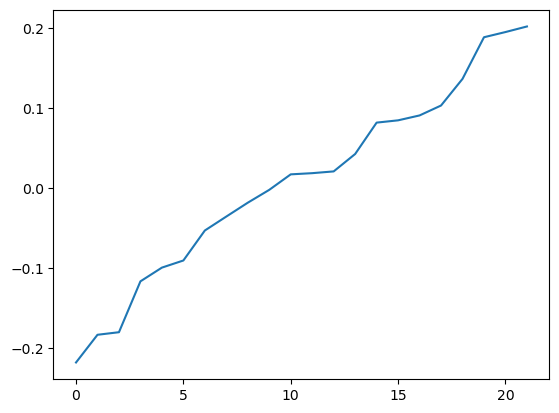

fit df.shape (253385, 40)
Epoch 1/1000
44/44 - 2s - loss: 1.0620 - mse: 1.0069 - weighted_mse: 0.9784 - cosine_similarity: 0.1268 - val_loss: 0.7946 - val_mse: 1.0017 - val_weighted_mse: 0.9889 - val_cosine_similarity: 0.1207 - 2s/epoch - 53ms/step
Epoch 2/1000
44/44 - 1s - loss: 1.0448 - mse: 1.0028 - weighted_mse: 0.9625 - cosine_similarity: 0.1695 - val_loss: 0.7902 - val_mse: 0.9989 - val_weighted_mse: 0.9834 - val_cosine_similarity: 0.1003 - 591ms/epoch - 13ms/step
Epoch 3/1000
44/44 - 1s - loss: 1.0348 - mse: 0.9992 - weighted_mse: 0.9534 - cosine_similarity: 0.1774 - val_loss: 0.7888 - val_mse: 0.9998 - val_weighted_mse: 0.9817 - val_cosine_similarity: 0.1069 - 588ms/epoch - 13ms/step
Epoch 4/1000
44/44 - 1s - loss: 1.0284 - mse: 1.0000 - weighted_mse: 0.9474 - cosine_similarity: 0.1831 - val_loss: 0.7876 - val_mse: 0.9980 - val_weighted_mse: 0.9801 - val_cosine_similarity: 0.1070 - 587ms/epoch - 13ms/step
Epoch 5/1000
44/44 - 1s - loss: 1.0236 - mse: 0.9990 - weighted_mse: 0.94

INFO:tensorflow:Assets written to: /tmp/tmp2q_ln7wf/assets


INFO:tensorflow:Assets written to: /tmp/tmp2q_ln7wf/assets
2022-11-22 23:24:15.723508: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:24:15.723599: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:24:15.723801: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp2q_ln7wf
2022-11-22 23:24:15.725952: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:24:15.725996: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp2q_ln7wf
2022-11-22 23:24:15.732961: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:24:15.791796: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp2q_ln7wf
2022-11-22 23:24:15.807196: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpocdicqbr/assets


INFO:tensorflow:Assets written to: /tmp/tmpocdicqbr/assets
2022-11-22 23:24:17.518592: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:24:17.518679: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:24:17.518874: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpocdicqbr
2022-11-22 23:24:17.520972: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:24:17.521012: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpocdicqbr
2022-11-22 23:24:17.527837: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:24:17.586571: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpocdicqbr
2022-11-22 23:24:17.602189: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpdrhwjpnv/assets


INFO:tensorflow:Assets written to: /tmp/tmpdrhwjpnv/assets
2022-11-22 23:24:19.300875: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:24:19.300961: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:24:19.301151: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpdrhwjpnv
2022-11-22 23:24:19.303262: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:24:19.303307: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpdrhwjpnv
2022-11-22 23:24:19.310225: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:24:19.369639: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpdrhwjpnv
2022-11-22 23:24:19.385258: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpo31gbbxb/assets


INFO:tensorflow:Assets written to: /tmp/tmpo31gbbxb/assets
2022-11-22 23:24:21.097247: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:24:21.097336: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:24:21.097560: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpo31gbbxb
2022-11-22 23:24:21.099682: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:24:21.099726: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpo31gbbxb
2022-11-22 23:24:21.106683: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:24:21.164546: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpo31gbbxb
2022-11-22 23:24:21.179902: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpapcp_qqz/assets


INFO:tensorflow:Assets written to: /tmp/tmpapcp_qqz/assets
2022-11-22 23:24:22.889356: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:24:22.889466: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:24:22.889658: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpapcp_qqz
2022-11-22 23:24:22.891762: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:24:22.891805: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpapcp_qqz
2022-11-22 23:24:22.898844: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:24:22.957567: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpapcp_qqz
2022-11-22 23:24:22.972771: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpgsc08m3q/assets


INFO:tensorflow:Assets written to: /tmp/tmpgsc08m3q/assets
2022-11-22 23:24:24.698429: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:24:24.698518: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:24:24.698723: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpgsc08m3q
2022-11-22 23:24:24.700833: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:24:24.700879: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpgsc08m3q
2022-11-22 23:24:24.707887: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:24:24.767064: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpgsc08m3q
2022-11-22 23:24:24.783027: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpeumthdw5/assets


INFO:tensorflow:Assets written to: /tmp/tmpeumthdw5/assets
2022-11-22 23:24:26.509072: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:24:26.509152: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:24:26.509346: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpeumthdw5
2022-11-22 23:24:26.511466: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:24:26.511511: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpeumthdw5
2022-11-22 23:24:26.518618: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:24:26.578046: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpeumthdw5
2022-11-22 23:24:26.593599: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpt8g3s4me/assets


INFO:tensorflow:Assets written to: /tmp/tmpt8g3s4me/assets
2022-11-22 23:24:28.323352: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:24:28.323433: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:24:28.323629: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpt8g3s4me
2022-11-22 23:24:28.325753: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:24:28.325795: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpt8g3s4me
2022-11-22 23:24:28.332560: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:24:28.388835: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpt8g3s4me
2022-11-22 23:24:28.403716: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpu6z1s723/assets


INFO:tensorflow:Assets written to: /tmp/tmpu6z1s723/assets
2022-11-22 23:24:30.116727: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:24:30.116819: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:24:30.117014: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpu6z1s723
2022-11-22 23:24:30.119155: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:24:30.119195: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpu6z1s723
2022-11-22 23:24:30.126040: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:24:30.185173: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpu6z1s723
2022-11-22 23:24:30.200101: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp4f1i8dgr/assets


INFO:tensorflow:Assets written to: /tmp/tmp4f1i8dgr/assets
2022-11-22 23:24:31.931578: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:24:31.931663: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:24:31.931864: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4f1i8dgr
2022-11-22 23:24:31.934286: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:24:31.934335: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4f1i8dgr
2022-11-22 23:24:31.944919: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:24:32.007120: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4f1i8dgr
2022-11-22 23:24:32.023105: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

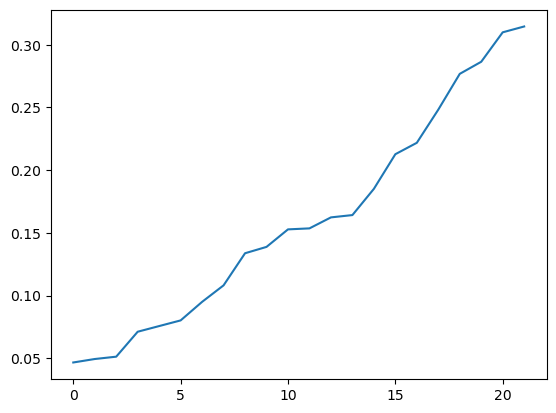

fit df.shape (238969, 40)
Epoch 1/1000
41/41 - 5s - loss: 1.0730 - mse: 1.0063 - weighted_mse: 0.9847 - cosine_similarity: 0.1137 - val_loss: 0.7847 - val_mse: 1.0000 - val_weighted_mse: 0.9882 - val_cosine_similarity: 0.0923 - 5s/epoch - 113ms/step
Epoch 2/1000
41/41 - 1s - loss: 1.0603 - mse: 1.0020 - weighted_mse: 0.9731 - cosine_similarity: 0.1431 - val_loss: 0.7825 - val_mse: 1.0000 - val_weighted_mse: 0.9854 - val_cosine_similarity: 0.1045 - 970ms/epoch - 24ms/step
Epoch 3/1000
41/41 - 1s - loss: 1.0521 - mse: 1.0006 - weighted_mse: 0.9656 - cosine_similarity: 0.1484 - val_loss: 0.7791 - val_mse: 0.9979 - val_weighted_mse: 0.9812 - val_cosine_similarity: 0.1088 - 962ms/epoch - 23ms/step
Epoch 4/1000
41/41 - 1s - loss: 1.0460 - mse: 0.9991 - weighted_mse: 0.9600 - cosine_similarity: 0.1577 - val_loss: 0.7793 - val_mse: 0.9978 - val_weighted_mse: 0.9815 - val_cosine_similarity: 0.1156 - 955ms/epoch - 23ms/step
Epoch 5/1000
41/41 - 1s - loss: 1.0404 - mse: 0.9992 - weighted_mse: 0.9

INFO:tensorflow:Assets written to: /tmp/tmppjif5yll/assets


INFO:tensorflow:Assets written to: /tmp/tmppjif5yll/assets
2022-11-22 23:31:15.468740: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:31:15.468860: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:31:15.469063: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmppjif5yll
2022-11-22 23:31:15.471278: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:31:15.471324: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmppjif5yll
2022-11-22 23:31:15.478609: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:31:15.536832: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmppjif5yll
2022-11-22 23:31:15.551671: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmphbn6dsh7/assets


INFO:tensorflow:Assets written to: /tmp/tmphbn6dsh7/assets
2022-11-22 23:31:17.273970: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:31:17.274074: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:31:17.274280: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmphbn6dsh7
2022-11-22 23:31:17.276444: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:31:17.276495: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmphbn6dsh7
2022-11-22 23:31:17.283611: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:31:17.346302: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmphbn6dsh7
2022-11-22 23:31:17.361078: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpsox1k_v3/assets


INFO:tensorflow:Assets written to: /tmp/tmpsox1k_v3/assets
2022-11-22 23:31:19.049320: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:31:19.049404: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:31:19.049606: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpsox1k_v3
2022-11-22 23:31:19.051711: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:31:19.051748: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpsox1k_v3
2022-11-22 23:31:19.058634: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:31:19.116068: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpsox1k_v3
2022-11-22 23:31:19.130896: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpht5pczda/assets


INFO:tensorflow:Assets written to: /tmp/tmpht5pczda/assets
2022-11-22 23:31:20.829405: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:31:20.829508: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:31:20.829697: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpht5pczda
2022-11-22 23:31:20.831782: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:31:20.831822: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpht5pczda
2022-11-22 23:31:20.838645: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:31:20.895212: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpht5pczda
2022-11-22 23:31:20.910097: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpz6_wefdm/assets


INFO:tensorflow:Assets written to: /tmp/tmpz6_wefdm/assets
2022-11-22 23:31:22.621295: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:31:22.621384: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:31:22.621602: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpz6_wefdm
2022-11-22 23:31:22.623756: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:31:22.623800: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpz6_wefdm
2022-11-22 23:31:22.630642: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:31:22.688831: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpz6_wefdm
2022-11-22 23:31:22.704358: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp7ly1o15q/assets


INFO:tensorflow:Assets written to: /tmp/tmp7ly1o15q/assets
2022-11-22 23:31:24.418828: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:31:24.418911: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:31:24.419098: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp7ly1o15q
2022-11-22 23:31:24.421143: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:31:24.421182: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp7ly1o15q
2022-11-22 23:31:24.427909: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:31:24.484582: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp7ly1o15q
2022-11-22 23:31:24.499287: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpki17ngq9/assets


INFO:tensorflow:Assets written to: /tmp/tmpki17ngq9/assets
2022-11-22 23:31:26.211889: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:31:26.211974: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:31:26.212176: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpki17ngq9
2022-11-22 23:31:26.214299: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:31:26.214343: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpki17ngq9
2022-11-22 23:31:26.221173: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:31:26.279745: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpki17ngq9
2022-11-22 23:31:26.294703: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1xybqho7/assets


INFO:tensorflow:Assets written to: /tmp/tmp1xybqho7/assets
2022-11-22 23:31:28.020949: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:31:28.021033: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:31:28.021227: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1xybqho7
2022-11-22 23:31:28.023360: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:31:28.023405: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1xybqho7
2022-11-22 23:31:28.030508: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:31:28.089159: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1xybqho7
2022-11-22 23:31:28.105093: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpx_v54lqt/assets


INFO:tensorflow:Assets written to: /tmp/tmpx_v54lqt/assets
2022-11-22 23:31:29.874801: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:31:29.874889: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:31:29.875082: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpx_v54lqt
2022-11-22 23:31:29.877220: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:31:29.877262: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpx_v54lqt
2022-11-22 23:31:29.884075: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:31:29.941060: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpx_v54lqt
2022-11-22 23:31:29.955516: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpua3hqss8/assets


INFO:tensorflow:Assets written to: /tmp/tmpua3hqss8/assets
2022-11-22 23:31:31.727701: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:31:31.727795: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:31:31.727992: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpua3hqss8
2022-11-22 23:31:31.730902: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:31:31.730952: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpua3hqss8
2022-11-22 23:31:31.748463: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:31:31.811251: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpua3hqss8
2022-11-22 23:31:31.826345: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

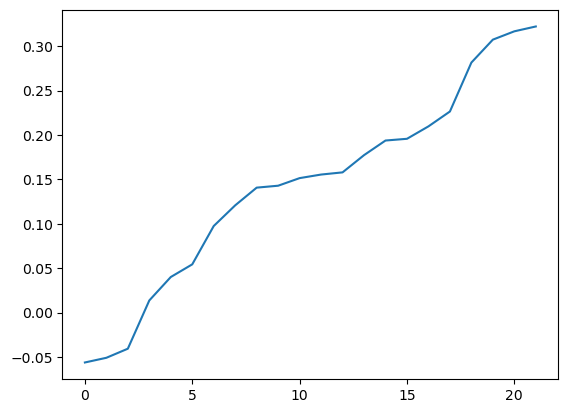

fit df.shape (225239, 40)
Epoch 1/1000
39/39 - 2s - loss: 1.0213 - mse: 0.9999 - weighted_mse: 0.9893 - cosine_similarity: 0.1013 - val_loss: 0.9188 - val_mse: 0.9987 - val_weighted_mse: 0.9901 - val_cosine_similarity: 0.0288 - 2s/epoch - 60ms/step
Epoch 2/1000
39/39 - 1s - loss: 1.0092 - mse: 0.9949 - weighted_mse: 0.9776 - cosine_similarity: 0.1233 - val_loss: 0.9128 - val_mse: 0.9964 - val_weighted_mse: 0.9837 - val_cosine_similarity: 0.0995 - 531ms/epoch - 14ms/step
Epoch 3/1000
39/39 - 1s - loss: 0.9999 - mse: 0.9916 - weighted_mse: 0.9687 - cosine_similarity: 0.1363 - val_loss: 0.9098 - val_mse: 0.9970 - val_weighted_mse: 0.9804 - val_cosine_similarity: 0.1038 - 532ms/epoch - 14ms/step
Epoch 4/1000
39/39 - 1s - loss: 0.9932 - mse: 0.9923 - weighted_mse: 0.9622 - cosine_similarity: 0.1484 - val_loss: 0.9081 - val_mse: 0.9947 - val_weighted_mse: 0.9786 - val_cosine_similarity: 0.1093 - 512ms/epoch - 13ms/step
Epoch 5/1000
39/39 - 1s - loss: 0.9883 - mse: 0.9923 - weighted_mse: 0.95

INFO:tensorflow:Assets written to: /tmp/tmp_5onv8lx/assets


INFO:tensorflow:Assets written to: /tmp/tmp_5onv8lx/assets
2022-11-22 23:36:39.235307: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:36:39.235402: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:36:39.235614: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_5onv8lx
2022-11-22 23:36:39.237798: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:36:39.237843: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_5onv8lx
2022-11-22 23:36:39.244984: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:36:39.302811: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_5onv8lx
2022-11-22 23:36:39.318230: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp9ctg1ozw/assets


INFO:tensorflow:Assets written to: /tmp/tmp9ctg1ozw/assets
2022-11-22 23:36:41.057918: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:36:41.058006: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:36:41.058200: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp9ctg1ozw
2022-11-22 23:36:41.060351: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:36:41.060394: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp9ctg1ozw
2022-11-22 23:36:41.067409: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:36:41.127116: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp9ctg1ozw
2022-11-22 23:36:41.142771: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmprbxxfvyg/assets


INFO:tensorflow:Assets written to: /tmp/tmprbxxfvyg/assets
2022-11-22 23:36:42.894220: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:36:42.894305: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:36:42.894499: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmprbxxfvyg
2022-11-22 23:36:42.896593: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:36:42.896636: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmprbxxfvyg
2022-11-22 23:36:42.903526: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:36:42.961773: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmprbxxfvyg
2022-11-22 23:36:42.978441: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpq7pnlwkw/assets


INFO:tensorflow:Assets written to: /tmp/tmpq7pnlwkw/assets
2022-11-22 23:36:44.730973: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:36:44.731065: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:36:44.731265: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpq7pnlwkw
2022-11-22 23:36:44.733457: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:36:44.733503: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpq7pnlwkw
2022-11-22 23:36:44.740383: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:36:44.799109: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpq7pnlwkw
2022-11-22 23:36:44.814202: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpummgq4ul/assets


INFO:tensorflow:Assets written to: /tmp/tmpummgq4ul/assets
2022-11-22 23:36:46.566420: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:36:46.566517: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:36:46.566724: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpummgq4ul
2022-11-22 23:36:46.568869: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:36:46.568922: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpummgq4ul
2022-11-22 23:36:46.576116: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:36:46.635906: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpummgq4ul
2022-11-22 23:36:46.651594: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpody6noap/assets


INFO:tensorflow:Assets written to: /tmp/tmpody6noap/assets
2022-11-22 23:36:48.448036: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:36:48.448131: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:36:48.448325: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpody6noap
2022-11-22 23:36:48.450482: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:36:48.450526: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpody6noap
2022-11-22 23:36:48.457600: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:36:48.515447: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpody6noap
2022-11-22 23:36:48.530540: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmphh7wice9/assets


INFO:tensorflow:Assets written to: /tmp/tmphh7wice9/assets
2022-11-22 23:36:50.285874: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:36:50.285961: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:36:50.286153: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmphh7wice9
2022-11-22 23:36:50.288266: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:36:50.288306: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmphh7wice9
2022-11-22 23:36:50.295260: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:36:50.352801: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmphh7wice9
2022-11-22 23:36:50.367727: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpaew1ir4h/assets


INFO:tensorflow:Assets written to: /tmp/tmpaew1ir4h/assets
2022-11-22 23:36:52.120271: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:36:52.120356: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:36:52.120560: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpaew1ir4h
2022-11-22 23:36:52.122735: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:36:52.122778: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpaew1ir4h
2022-11-22 23:36:52.130386: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:36:52.190135: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpaew1ir4h
2022-11-22 23:36:52.206775: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_lovi2zn/assets


INFO:tensorflow:Assets written to: /tmp/tmp_lovi2zn/assets
2022-11-22 23:36:53.945191: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:36:53.945280: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:36:53.945489: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_lovi2zn
2022-11-22 23:36:53.947599: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:36:53.947642: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_lovi2zn
2022-11-22 23:36:53.954723: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:36:54.014168: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_lovi2zn
2022-11-22 23:36:54.029684: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpndoi45eb/assets


INFO:tensorflow:Assets written to: /tmp/tmpndoi45eb/assets
2022-11-22 23:36:55.792357: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:36:55.792454: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:36:55.792658: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpndoi45eb
2022-11-22 23:36:55.794875: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:36:55.794928: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpndoi45eb
2022-11-22 23:36:55.802745: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:36:55.864039: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpndoi45eb
2022-11-22 23:36:55.880542: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

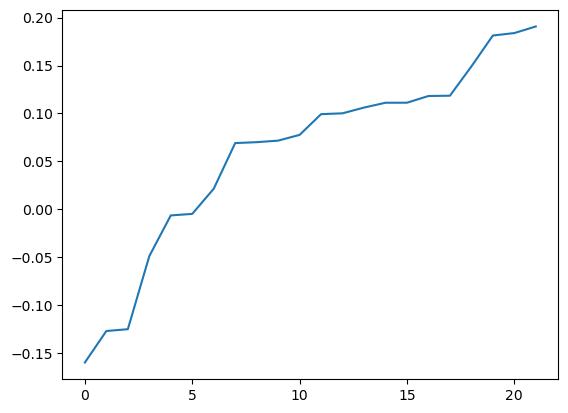

fit df.shape (225464, 40)
Epoch 1/1000
39/39 - 2s - loss: 0.8834 - mse: 0.9990 - weighted_mse: 0.9851 - cosine_similarity: 0.1096 - val_loss: 1.2195 - val_mse: 1.0017 - val_weighted_mse: 0.9828 - val_cosine_similarity: 0.1268 - 2s/epoch - 63ms/step
Epoch 2/1000
39/39 - 1s - loss: 0.8685 - mse: 0.9924 - weighted_mse: 0.9685 - cosine_similarity: 0.1491 - val_loss: 1.2160 - val_mse: 0.9985 - val_weighted_mse: 0.9800 - val_cosine_similarity: 0.1278 - 537ms/epoch - 14ms/step
Epoch 3/1000
39/39 - 1s - loss: 0.8608 - mse: 0.9908 - weighted_mse: 0.9598 - cosine_similarity: 0.1598 - val_loss: 1.2180 - val_mse: 0.9981 - val_weighted_mse: 0.9815 - val_cosine_similarity: 0.0910 - 533ms/epoch - 14ms/step
Epoch 4/1000
39/39 - 1s - loss: 0.8559 - mse: 0.9896 - weighted_mse: 0.9544 - cosine_similarity: 0.1709 - val_loss: 1.2156 - val_mse: 0.9979 - val_weighted_mse: 0.9797 - val_cosine_similarity: 0.1031 - 532ms/epoch - 14ms/step
Epoch 5/1000
39/39 - 1s - loss: 0.8512 - mse: 0.9896 - weighted_mse: 0.94

INFO:tensorflow:Assets written to: /tmp/tmpznhpr1of/assets


INFO:tensorflow:Assets written to: /tmp/tmpznhpr1of/assets
2022-11-22 23:43:47.634468: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:43:47.634555: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:43:47.634766: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpznhpr1of
2022-11-22 23:43:47.636893: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:43:47.636938: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpznhpr1of
2022-11-22 23:43:47.643966: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:43:47.701520: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpznhpr1of
2022-11-22 23:43:47.716511: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5c78l2kp/assets


INFO:tensorflow:Assets written to: /tmp/tmp5c78l2kp/assets
2022-11-22 23:43:49.427334: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:43:49.427418: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:43:49.427617: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5c78l2kp
2022-11-22 23:43:49.429740: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:43:49.429783: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5c78l2kp
2022-11-22 23:43:49.436682: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:43:49.493955: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5c78l2kp
2022-11-22 23:43:49.508662: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpeeeugdre/assets


INFO:tensorflow:Assets written to: /tmp/tmpeeeugdre/assets
2022-11-22 23:43:51.179865: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:43:51.179948: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:43:51.180137: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpeeeugdre
2022-11-22 23:43:51.182279: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:43:51.182325: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpeeeugdre
2022-11-22 23:43:51.189148: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:43:51.246688: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpeeeugdre
2022-11-22 23:43:51.261323: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpuo88e2nc/assets


INFO:tensorflow:Assets written to: /tmp/tmpuo88e2nc/assets
2022-11-22 23:43:52.966672: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:43:52.966749: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:43:52.966934: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpuo88e2nc
2022-11-22 23:43:52.968995: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:43:52.969036: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpuo88e2nc
2022-11-22 23:43:52.975874: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:43:53.033512: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpuo88e2nc
2022-11-22 23:43:53.048163: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5ehspmi7/assets


INFO:tensorflow:Assets written to: /tmp/tmp5ehspmi7/assets
2022-11-22 23:43:54.721748: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:43:54.721839: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:43:54.722036: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5ehspmi7
2022-11-22 23:43:54.724167: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:43:54.724211: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5ehspmi7
2022-11-22 23:43:54.731204: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:43:54.788579: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5ehspmi7
2022-11-22 23:43:54.803299: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpcwnq4sbx/assets


INFO:tensorflow:Assets written to: /tmp/tmpcwnq4sbx/assets
2022-11-22 23:43:56.494221: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:43:56.494305: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:43:56.494488: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpcwnq4sbx
2022-11-22 23:43:56.496528: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:43:56.496566: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpcwnq4sbx
2022-11-22 23:43:56.503358: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:43:56.561558: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpcwnq4sbx
2022-11-22 23:43:56.576046: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmps7gkzp5w/assets


INFO:tensorflow:Assets written to: /tmp/tmps7gkzp5w/assets
2022-11-22 23:43:58.271683: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:43:58.271764: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:43:58.271947: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmps7gkzp5w
2022-11-22 23:43:58.274051: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:43:58.274092: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmps7gkzp5w
2022-11-22 23:43:58.280700: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:43:58.337290: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmps7gkzp5w
2022-11-22 23:43:58.351568: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpil8it0w8/assets


INFO:tensorflow:Assets written to: /tmp/tmpil8it0w8/assets
2022-11-22 23:44:00.011970: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:44:00.012054: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:44:00.012244: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpil8it0w8
2022-11-22 23:44:00.014327: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:44:00.014370: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpil8it0w8
2022-11-22 23:44:00.020998: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:44:00.077144: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpil8it0w8
2022-11-22 23:44:00.091859: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpge83kzap/assets


INFO:tensorflow:Assets written to: /tmp/tmpge83kzap/assets
2022-11-22 23:44:01.779283: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:44:01.779367: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:44:01.779558: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpge83kzap
2022-11-22 23:44:01.781633: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:44:01.781671: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpge83kzap
2022-11-22 23:44:01.788470: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:44:01.846850: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpge83kzap
2022-11-22 23:44:01.861965: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpqrzjx8mz/assets


INFO:tensorflow:Assets written to: /tmp/tmpqrzjx8mz/assets
2022-11-22 23:44:03.549749: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 23:44:03.549828: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 23:44:03.550015: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqrzjx8mz
2022-11-22 23:44:03.552078: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 23:44:03.552126: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqrzjx8mz
2022-11-22 23:44:03.558920: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 23:44:03.614999: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqrzjx8mz
2022-11-22 23:44:03.629360: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

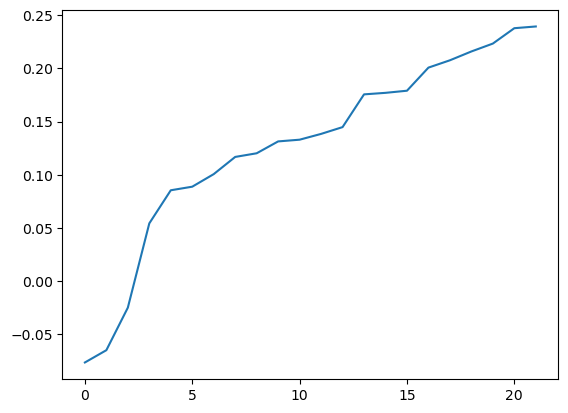

return without cost statistics
mean 0.00286791437348814
std 0.017455525072201983
sharpe 0.164298373244315
double sharpe 1.4372969413810615
max drawdown 3.521392829938577
min -0.14580242120936174
min sharpe 0.01966986796035453
return with cost statistics
mean 0.0017950057823525425
std 0.017479779843442327
sharpe 0.10269041134553834
double sharpe 0.8338574694981107
max drawdown 4.9456700041743495
min -0.14716282834623354
min sharpe 0.012197412910068492


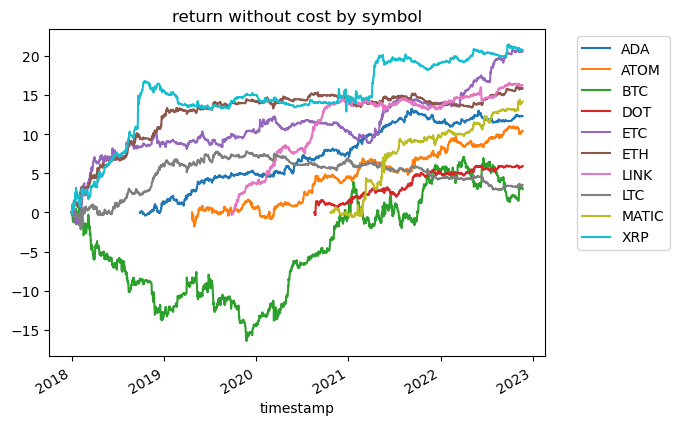

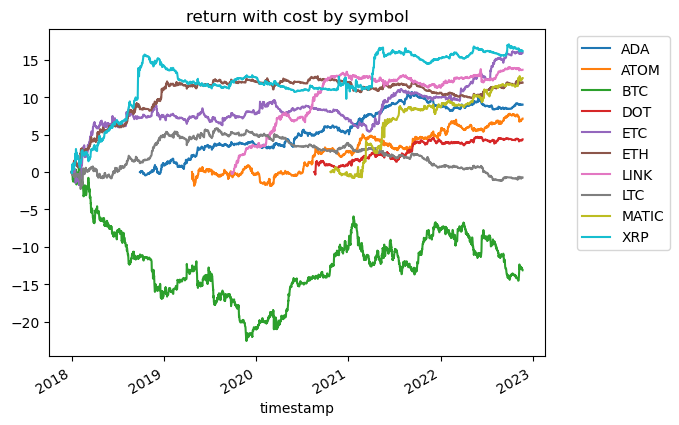

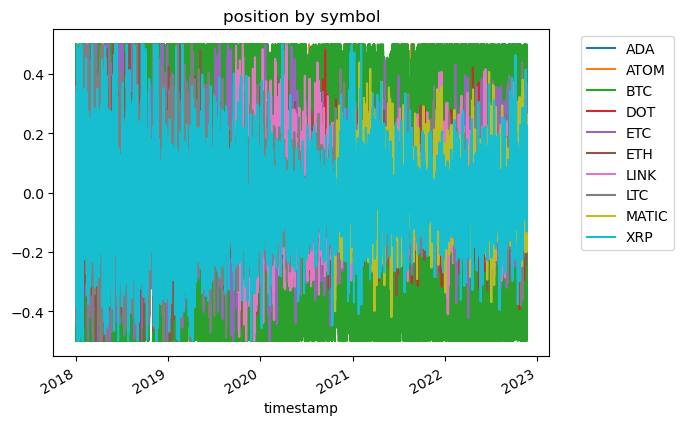

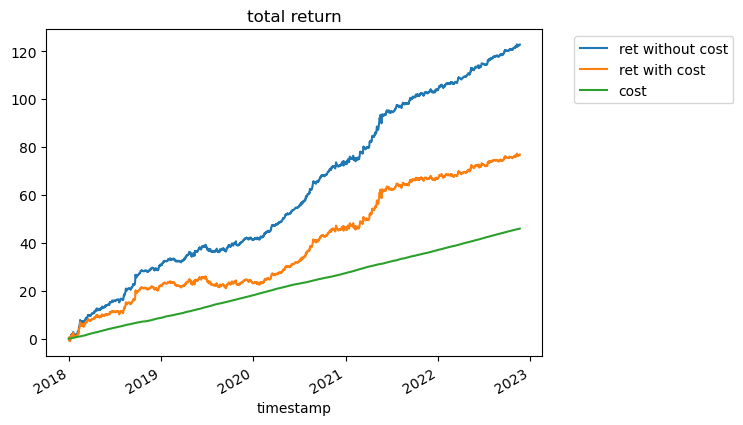

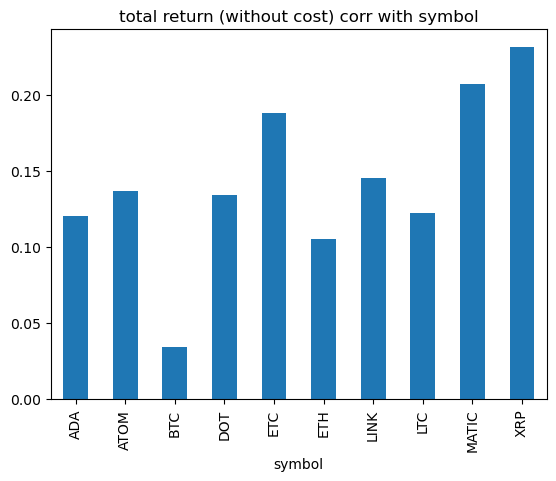

return without cost statistics
mean 0.0028057645525028587
std 0.01745957910708841
sharpe 0.1607005836334134
double sharpe 1.2902575104719383
max drawdown 5.668423341066821
min -0.14580242120936174
min sharpe 0.019243607405352917
return with cost statistics
mean 0.0017883915851101013
std 0.01745939667665018
sharpe 0.10243146531528537
double sharpe 0.8381249583056293
max drawdown 6.258049845001165
min -0.14716282834623354
min sharpe 0.012152468155222657


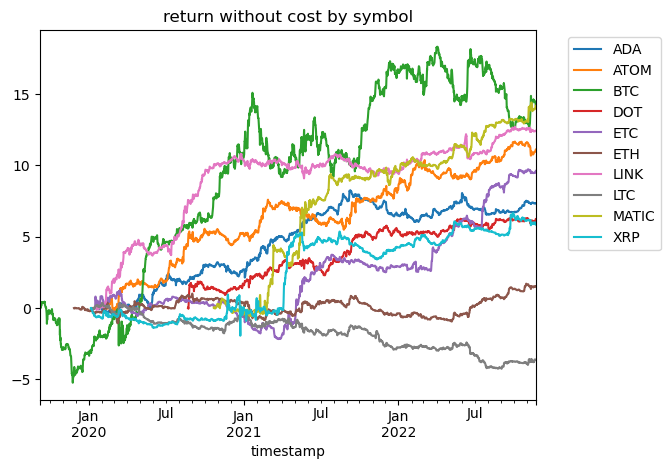

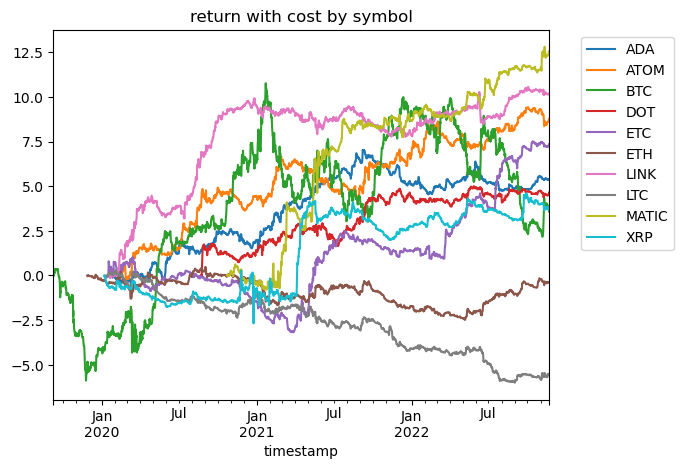

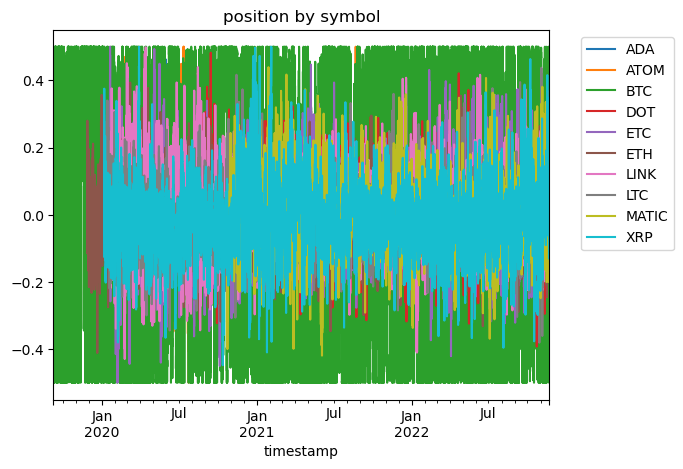

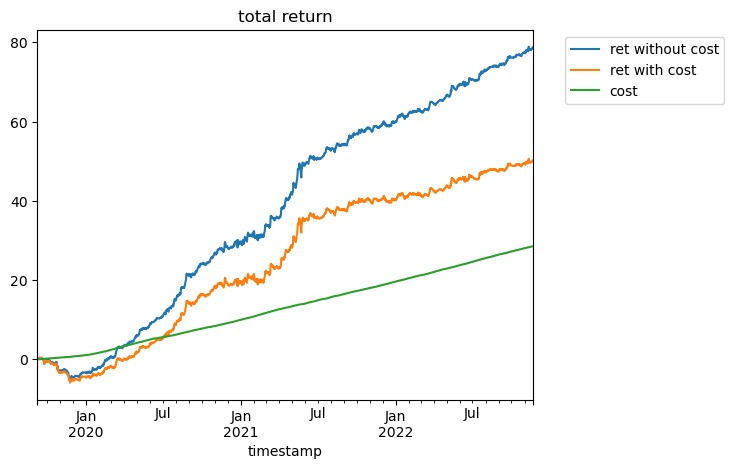

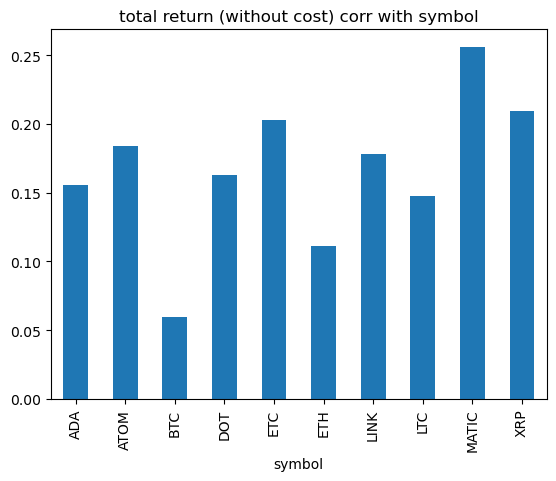

fit df.shape (302747, 40)


INFO:tensorflow:Assets written to: /tmp/tmpvozg1wrt/assets


INFO:tensorflow:Assets written to: /tmp/tmpvozg1wrt/assets
2022-11-23 00:51:37.074144: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:51:37.074224: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:51:37.074420: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvozg1wrt
2022-11-23 00:51:37.076525: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:51:37.076581: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvozg1wrt
2022-11-23 00:51:37.083635: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:51:37.142067: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvozg1wrt
2022-11-23 00:51:37.158335: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmplcv4r19q/assets


INFO:tensorflow:Assets written to: /tmp/tmplcv4r19q/assets
2022-11-23 00:51:38.836241: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:51:38.836322: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:51:38.836511: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmplcv4r19q
2022-11-23 00:51:38.838608: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:51:38.838650: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmplcv4r19q
2022-11-23 00:51:38.845700: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:51:38.903499: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmplcv4r19q
2022-11-23 00:51:38.918544: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmph_0pl5ab/assets


INFO:tensorflow:Assets written to: /tmp/tmph_0pl5ab/assets
2022-11-23 00:51:40.594996: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:51:40.595076: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:51:40.595259: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmph_0pl5ab
2022-11-23 00:51:40.597308: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:51:40.597348: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmph_0pl5ab
2022-11-23 00:51:40.604281: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:51:40.661706: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmph_0pl5ab
2022-11-23 00:51:40.677770: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpo6a8xiuo/assets


INFO:tensorflow:Assets written to: /tmp/tmpo6a8xiuo/assets
2022-11-23 00:51:42.356071: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:51:42.356162: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:51:42.356369: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpo6a8xiuo
2022-11-23 00:51:42.358497: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:51:42.358556: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpo6a8xiuo
2022-11-23 00:51:42.365696: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:51:42.427523: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpo6a8xiuo
2022-11-23 00:51:42.442674: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpllli5djm/assets


INFO:tensorflow:Assets written to: /tmp/tmpllli5djm/assets
2022-11-23 00:51:44.120861: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:51:44.120941: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:51:44.121127: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpllli5djm
2022-11-23 00:51:44.123184: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:51:44.123224: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpllli5djm
2022-11-23 00:51:44.130172: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:51:44.187688: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpllli5djm
2022-11-23 00:51:44.201988: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpa3m3kne1/assets


INFO:tensorflow:Assets written to: /tmp/tmpa3m3kne1/assets
2022-11-23 00:51:45.868842: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:51:45.868921: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:51:45.869111: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpa3m3kne1
2022-11-23 00:51:45.871195: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:51:45.871235: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpa3m3kne1
2022-11-23 00:51:45.878277: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:51:45.935901: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpa3m3kne1
2022-11-23 00:51:45.950641: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpubyj2two/assets


INFO:tensorflow:Assets written to: /tmp/tmpubyj2two/assets
2022-11-23 00:51:47.625405: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:51:47.625502: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:51:47.625703: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpubyj2two
2022-11-23 00:51:47.627783: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:51:47.627822: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpubyj2two
2022-11-23 00:51:47.634815: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:51:47.692661: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpubyj2two
2022-11-23 00:51:47.707247: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpqpzgffc8/assets


INFO:tensorflow:Assets written to: /tmp/tmpqpzgffc8/assets
2022-11-23 00:51:49.411056: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:51:49.411142: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:51:49.411346: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqpzgffc8
2022-11-23 00:51:49.413491: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:51:49.413543: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqpzgffc8
2022-11-23 00:51:49.420850: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:51:49.485304: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqpzgffc8
2022-11-23 00:51:49.500306: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp9c5kt1f6/assets


INFO:tensorflow:Assets written to: /tmp/tmp9c5kt1f6/assets
2022-11-23 00:51:51.176960: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:51:51.177045: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:51:51.177236: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp9c5kt1f6
2022-11-23 00:51:51.179307: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:51:51.179351: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp9c5kt1f6
2022-11-23 00:51:51.186400: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:51:51.244712: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp9c5kt1f6
2022-11-23 00:51:51.259409: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpv912mxb_/assets


INFO:tensorflow:Assets written to: /tmp/tmpv912mxb_/assets
2022-11-23 00:51:52.944689: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:51:52.944769: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:51:52.944957: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpv912mxb_
2022-11-23 00:51:52.947049: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:51:52.947090: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpv912mxb_
2022-11-23 00:51:52.954194: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:51:53.011947: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpv912mxb_
2022-11-23 00:51:53.026970: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp7mdobuj_/assets


INFO:tensorflow:Assets written to: /tmp/tmp7mdobuj_/assets
2022-11-23 00:51:54.724144: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:51:54.724221: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:51:54.724429: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp7mdobuj_
2022-11-23 00:51:54.726522: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:51:54.726561: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp7mdobuj_
2022-11-23 00:51:54.733565: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:51:54.791098: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp7mdobuj_
2022-11-23 00:51:54.805761: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpxtldu7bh/assets


INFO:tensorflow:Assets written to: /tmp/tmpxtldu7bh/assets
2022-11-23 00:51:58.772045: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:51:58.772128: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:51:58.772347: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxtldu7bh
2022-11-23 00:51:58.776156: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:51:58.776201: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxtldu7bh
2022-11-23 00:51:58.789122: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:51:58.854830: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpxtldu7bh
2022-11-23 00:51:58.873053: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpw9r6sa8e/assets


INFO:tensorflow:Assets written to: /tmp/tmpw9r6sa8e/assets
2022-11-23 00:52:00.636694: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:52:00.636777: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:52:00.636965: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpw9r6sa8e
2022-11-23 00:52:00.639405: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:52:00.639450: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpw9r6sa8e
2022-11-23 00:52:00.647466: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:52:00.707863: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpw9r6sa8e
2022-11-23 00:52:00.723316: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp10lw7xhl/assets


INFO:tensorflow:Assets written to: /tmp/tmp10lw7xhl/assets
2022-11-23 00:52:02.436332: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:52:02.436411: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:52:02.436609: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp10lw7xhl
2022-11-23 00:52:02.438805: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:52:02.438844: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp10lw7xhl
2022-11-23 00:52:02.446036: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:52:02.504641: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp10lw7xhl
2022-11-23 00:52:02.519675: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpu_ce67z_/assets


INFO:tensorflow:Assets written to: /tmp/tmpu_ce67z_/assets
2022-11-23 00:52:04.180095: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:52:04.180179: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:52:04.180366: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpu_ce67z_
2022-11-23 00:52:04.182531: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:52:04.182573: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpu_ce67z_
2022-11-23 00:52:04.189580: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:52:04.247517: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpu_ce67z_
2022-11-23 00:52:04.262778: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp9mtkaklb/assets


INFO:tensorflow:Assets written to: /tmp/tmp9mtkaklb/assets
2022-11-23 00:52:05.956737: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:52:05.956813: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:52:05.957000: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp9mtkaklb
2022-11-23 00:52:05.959119: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:52:05.959159: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp9mtkaklb
2022-11-23 00:52:05.966058: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:52:06.023723: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp9mtkaklb
2022-11-23 00:52:06.038578: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp503fnwtl/assets


INFO:tensorflow:Assets written to: /tmp/tmp503fnwtl/assets
2022-11-23 00:52:07.711084: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:52:07.711178: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:52:07.711367: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp503fnwtl
2022-11-23 00:52:07.713525: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:52:07.713564: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp503fnwtl
2022-11-23 00:52:07.720439: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:52:07.777213: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp503fnwtl
2022-11-23 00:52:07.791966: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp4jct5cph/assets


INFO:tensorflow:Assets written to: /tmp/tmp4jct5cph/assets
2022-11-23 00:52:09.450996: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:52:09.451073: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:52:09.451260: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4jct5cph
2022-11-23 00:52:09.453370: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:52:09.453409: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4jct5cph
2022-11-23 00:52:09.460177: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:52:09.517960: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4jct5cph
2022-11-23 00:52:09.532448: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpte3qn7up/assets


INFO:tensorflow:Assets written to: /tmp/tmpte3qn7up/assets
2022-11-23 00:52:11.212768: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:52:11.212859: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:52:11.213061: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpte3qn7up
2022-11-23 00:52:11.215185: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:52:11.215232: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpte3qn7up
2022-11-23 00:52:11.222385: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:52:11.280958: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpte3qn7up
2022-11-23 00:52:11.295534: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp14pskava/assets


INFO:tensorflow:Assets written to: /tmp/tmp14pskava/assets
2022-11-23 00:52:12.977365: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:52:12.977462: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:52:12.977658: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp14pskava
2022-11-23 00:52:12.979736: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:52:12.979774: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp14pskava
2022-11-23 00:52:12.986567: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:52:13.043762: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp14pskava
2022-11-23 00:52:13.058743: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp6ld0n5rd/assets


INFO:tensorflow:Assets written to: /tmp/tmp6ld0n5rd/assets
2022-11-23 00:52:14.708139: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:52:14.708212: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:52:14.708396: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp6ld0n5rd
2022-11-23 00:52:14.710450: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:52:14.710490: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp6ld0n5rd
2022-11-23 00:52:14.717171: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:52:14.774499: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp6ld0n5rd
2022-11-23 00:52:14.789204: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpvv_btsrl/assets


INFO:tensorflow:Assets written to: /tmp/tmpvv_btsrl/assets
2022-11-23 00:52:16.460583: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:52:16.460672: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:52:16.460859: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvv_btsrl
2022-11-23 00:52:16.462942: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:52:16.462985: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvv_btsrl
2022-11-23 00:52:16.469974: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:52:16.527909: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvv_btsrl
2022-11-23 00:52:16.542835: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpqai53_pi/assets


INFO:tensorflow:Assets written to: /tmp/tmpqai53_pi/assets
2022-11-23 00:52:18.247928: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:52:18.248014: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:52:18.248214: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqai53_pi
2022-11-23 00:52:18.250380: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:52:18.250429: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqai53_pi
2022-11-23 00:52:18.257802: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:52:18.321884: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqai53_pi
2022-11-23 00:52:18.336739: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpp28xbcoz/assets


INFO:tensorflow:Assets written to: /tmp/tmpp28xbcoz/assets
2022-11-23 00:52:20.053234: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:52:20.053319: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:52:20.053547: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpp28xbcoz
2022-11-23 00:52:20.055643: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:52:20.055693: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpp28xbcoz
2022-11-23 00:52:20.062989: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:52:20.127052: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpp28xbcoz
2022-11-23 00:52:20.142786: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpmrv05qeh/assets


INFO:tensorflow:Assets written to: /tmp/tmpmrv05qeh/assets
2022-11-23 00:52:24.161971: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:52:24.162065: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:52:24.162289: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpmrv05qeh
2022-11-23 00:52:24.166297: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:52:24.166344: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpmrv05qeh
2022-11-23 00:52:24.181226: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:52:24.260797: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpmrv05qeh
2022-11-23 00:52:24.284319: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpj7dr0lmm/assets


INFO:tensorflow:Assets written to: /tmp/tmpj7dr0lmm/assets
2022-11-23 00:52:26.107545: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:52:26.107633: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:52:26.107823: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpj7dr0lmm
2022-11-23 00:52:26.110908: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:52:26.110953: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpj7dr0lmm
2022-11-23 00:52:26.120314: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:52:26.186916: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpj7dr0lmm
2022-11-23 00:52:26.203557: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpatsb0ygv/assets


INFO:tensorflow:Assets written to: /tmp/tmpatsb0ygv/assets
2022-11-23 00:52:27.934344: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:52:27.934424: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:52:27.934623: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpatsb0ygv
2022-11-23 00:52:27.937014: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:52:27.937059: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpatsb0ygv
2022-11-23 00:52:27.945118: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:52:28.007302: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpatsb0ygv
2022-11-23 00:52:28.023538: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpsae2xgpn/assets


INFO:tensorflow:Assets written to: /tmp/tmpsae2xgpn/assets
2022-11-23 00:52:29.744090: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:52:29.744164: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:52:29.744352: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpsae2xgpn
2022-11-23 00:52:29.746563: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:52:29.746613: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpsae2xgpn
2022-11-23 00:52:29.754010: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:52:29.812943: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpsae2xgpn
2022-11-23 00:52:29.828059: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpn4po_sne/assets


INFO:tensorflow:Assets written to: /tmp/tmpn4po_sne/assets
2022-11-23 00:52:31.538563: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:52:31.538645: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:52:31.538837: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpn4po_sne
2022-11-23 00:52:31.540987: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:52:31.541030: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpn4po_sne
2022-11-23 00:52:31.548134: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:52:31.606767: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpn4po_sne
2022-11-23 00:52:31.621739: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp3hxosi53/assets


INFO:tensorflow:Assets written to: /tmp/tmp3hxosi53/assets
2022-11-23 00:52:33.343937: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:52:33.344018: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:52:33.344207: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp3hxosi53
2022-11-23 00:52:33.346342: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:52:33.346383: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp3hxosi53
2022-11-23 00:52:33.353401: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:52:33.411041: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp3hxosi53
2022-11-23 00:52:33.426003: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpne5gk9wq/assets


INFO:tensorflow:Assets written to: /tmp/tmpne5gk9wq/assets
2022-11-23 00:52:35.112522: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:52:35.112614: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:52:35.112803: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpne5gk9wq
2022-11-23 00:52:35.114967: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:52:35.115012: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpne5gk9wq
2022-11-23 00:52:35.121944: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:52:35.180143: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpne5gk9wq
2022-11-23 00:52:35.194828: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmph51e1wdw/assets


INFO:tensorflow:Assets written to: /tmp/tmph51e1wdw/assets
2022-11-23 00:52:36.897119: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:52:36.897204: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:52:36.897396: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmph51e1wdw
2022-11-23 00:52:36.899544: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:52:36.899602: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmph51e1wdw
2022-11-23 00:52:36.906768: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:52:36.965302: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmph51e1wdw
2022-11-23 00:52:36.980646: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp9d5kyyn2/assets


INFO:tensorflow:Assets written to: /tmp/tmp9d5kyyn2/assets
2022-11-23 00:52:38.681151: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:52:38.681232: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:52:38.681434: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp9d5kyyn2
2022-11-23 00:52:38.683547: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:52:38.683589: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp9d5kyyn2
2022-11-23 00:52:38.690472: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:52:38.749479: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp9d5kyyn2
2022-11-23 00:52:38.764372: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpwki47s8e/assets


INFO:tensorflow:Assets written to: /tmp/tmpwki47s8e/assets
2022-11-23 00:52:40.450059: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:52:40.450140: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:52:40.450330: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpwki47s8e
2022-11-23 00:52:40.452480: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:52:40.452525: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpwki47s8e
2022-11-23 00:52:40.459483: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:52:40.516674: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpwki47s8e
2022-11-23 00:52:40.531702: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpvdpaztso/assets


INFO:tensorflow:Assets written to: /tmp/tmpvdpaztso/assets
2022-11-23 00:52:42.214671: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:52:42.214756: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:52:42.214942: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvdpaztso
2022-11-23 00:52:42.217053: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:52:42.217093: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvdpaztso
2022-11-23 00:52:42.223998: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:52:42.282431: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvdpaztso
2022-11-23 00:52:42.297999: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpt3w1nm6s/assets


INFO:tensorflow:Assets written to: /tmp/tmpt3w1nm6s/assets
2022-11-23 00:52:43.974193: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:52:43.974274: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:52:43.974465: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpt3w1nm6s
2022-11-23 00:52:43.976588: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:52:43.976632: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpt3w1nm6s
2022-11-23 00:52:43.983493: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:52:44.040587: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpt3w1nm6s
2022-11-23 00:52:44.056170: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpkuvilk9y/assets


INFO:tensorflow:Assets written to: /tmp/tmpkuvilk9y/assets
2022-11-23 00:52:47.971791: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:52:47.971879: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:52:47.972086: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpkuvilk9y
2022-11-23 00:52:47.976654: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:52:47.976707: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpkuvilk9y
2022-11-23 00:52:47.993852: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:52:48.080161: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpkuvilk9y
2022-11-23 00:52:48.107328: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5ylgbffn/assets


INFO:tensorflow:Assets written to: /tmp/tmp5ylgbffn/assets
2022-11-23 00:52:50.019677: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:52:50.019766: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:52:50.019962: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5ylgbffn
2022-11-23 00:52:50.023284: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:52:50.023331: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5ylgbffn
2022-11-23 00:52:50.034570: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:52:50.099703: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5ylgbffn
2022-11-23 00:52:50.118122: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpufulogwy/assets


INFO:tensorflow:Assets written to: /tmp/tmpufulogwy/assets
2022-11-23 00:52:51.850374: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:52:51.850458: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:52:51.850649: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpufulogwy
2022-11-23 00:52:51.853137: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:52:51.853181: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpufulogwy
2022-11-23 00:52:51.861154: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:52:51.922247: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpufulogwy
2022-11-23 00:52:51.938143: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpex3t5f4p/assets


INFO:tensorflow:Assets written to: /tmp/tmpex3t5f4p/assets
2022-11-23 00:52:53.659222: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:52:53.659302: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:52:53.659495: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpex3t5f4p
2022-11-23 00:52:53.661732: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:52:53.661775: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpex3t5f4p
2022-11-23 00:52:53.669119: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:52:53.729018: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpex3t5f4p
2022-11-23 00:52:53.744691: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp6aft9yjy/assets


INFO:tensorflow:Assets written to: /tmp/tmp6aft9yjy/assets
2022-11-23 00:52:55.454627: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:52:55.454711: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:52:55.454903: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp6aft9yjy
2022-11-23 00:52:55.457071: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:52:55.457114: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp6aft9yjy
2022-11-23 00:52:55.464323: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:52:55.523905: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp6aft9yjy
2022-11-23 00:52:55.539074: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpzw9ij560/assets


INFO:tensorflow:Assets written to: /tmp/tmpzw9ij560/assets
2022-11-23 00:52:57.249743: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:52:57.249825: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:52:57.250015: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzw9ij560
2022-11-23 00:52:57.252150: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:52:57.252192: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpzw9ij560
2022-11-23 00:52:57.259307: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:52:57.317952: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpzw9ij560
2022-11-23 00:52:57.332932: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpkd2v7ew4/assets


INFO:tensorflow:Assets written to: /tmp/tmpkd2v7ew4/assets
2022-11-23 00:52:59.016421: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:52:59.016503: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:52:59.016690: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpkd2v7ew4
2022-11-23 00:52:59.018810: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:52:59.018849: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpkd2v7ew4
2022-11-23 00:52:59.025843: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:52:59.084410: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpkd2v7ew4
2022-11-23 00:52:59.099568: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1fgevnx5/assets


INFO:tensorflow:Assets written to: /tmp/tmp1fgevnx5/assets
2022-11-23 00:53:00.772793: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:53:00.772877: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:53:00.773067: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1fgevnx5
2022-11-23 00:53:00.775243: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:53:00.775287: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1fgevnx5
2022-11-23 00:53:00.782481: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:53:00.841489: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1fgevnx5
2022-11-23 00:53:00.856793: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpcdgm78qz/assets


INFO:tensorflow:Assets written to: /tmp/tmpcdgm78qz/assets
2022-11-23 00:53:02.540673: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:53:02.540760: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:53:02.540950: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpcdgm78qz
2022-11-23 00:53:02.543078: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:53:02.543120: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpcdgm78qz
2022-11-23 00:53:02.550214: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:53:02.608332: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpcdgm78qz
2022-11-23 00:53:02.623207: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpjexmxhlu/assets


INFO:tensorflow:Assets written to: /tmp/tmpjexmxhlu/assets
2022-11-23 00:53:04.298284: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:53:04.298369: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:53:04.298565: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpjexmxhlu
2022-11-23 00:53:04.300687: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:53:04.300730: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpjexmxhlu
2022-11-23 00:53:04.307741: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:53:04.367173: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpjexmxhlu
2022-11-23 00:53:04.382096: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmputjap68o/assets


INFO:tensorflow:Assets written to: /tmp/tmputjap68o/assets
2022-11-23 00:53:06.044583: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:53:06.044666: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:53:06.044864: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmputjap68o
2022-11-23 00:53:06.047000: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:53:06.047040: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmputjap68o
2022-11-23 00:53:06.053895: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:53:06.111170: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmputjap68o
2022-11-23 00:53:06.125830: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp2bo91gyp/assets


INFO:tensorflow:Assets written to: /tmp/tmp2bo91gyp/assets
2022-11-23 00:53:09.920866: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:53:09.920951: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:53:09.921150: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp2bo91gyp
2022-11-23 00:53:09.925716: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:53:09.925775: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp2bo91gyp
2022-11-23 00:53:09.942889: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:53:10.034186: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp2bo91gyp
2022-11-23 00:53:10.060771: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpex4hmc5d/assets


INFO:tensorflow:Assets written to: /tmp/tmpex4hmc5d/assets
2022-11-23 00:53:11.999716: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:53:11.999797: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:53:11.999990: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpex4hmc5d
2022-11-23 00:53:12.003325: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:53:12.003374: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpex4hmc5d
2022-11-23 00:53:12.014829: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:53:12.082178: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpex4hmc5d
2022-11-23 00:53:12.101011: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpvury49rl/assets


INFO:tensorflow:Assets written to: /tmp/tmpvury49rl/assets
2022-11-23 00:53:13.846621: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:53:13.846703: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:53:13.846901: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvury49rl
2022-11-23 00:53:13.849275: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:53:13.849317: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvury49rl
2022-11-23 00:53:13.857366: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:53:13.918393: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvury49rl
2022-11-23 00:53:13.934278: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp54fidr3l/assets


INFO:tensorflow:Assets written to: /tmp/tmp54fidr3l/assets
2022-11-23 00:53:15.630231: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:53:15.630315: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:53:15.630504: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp54fidr3l
2022-11-23 00:53:15.632782: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:53:15.632827: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp54fidr3l
2022-11-23 00:53:15.640398: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:53:15.701410: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp54fidr3l
2022-11-23 00:53:15.717043: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpohn2pjy1/assets


INFO:tensorflow:Assets written to: /tmp/tmpohn2pjy1/assets
2022-11-23 00:53:17.460366: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:53:17.460463: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:53:17.460681: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpohn2pjy1
2022-11-23 00:53:17.462979: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:53:17.463035: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpohn2pjy1
2022-11-23 00:53:17.470891: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:53:17.538917: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpohn2pjy1
2022-11-23 00:53:17.556136: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmphayo39_8/assets


INFO:tensorflow:Assets written to: /tmp/tmphayo39_8/assets
2022-11-23 00:53:19.274472: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:53:19.274562: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:53:19.274768: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmphayo39_8
2022-11-23 00:53:19.276954: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:53:19.277000: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmphayo39_8
2022-11-23 00:53:19.284624: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:53:19.345458: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmphayo39_8
2022-11-23 00:53:19.360507: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpwujbix0y/assets


INFO:tensorflow:Assets written to: /tmp/tmpwujbix0y/assets
2022-11-23 00:53:21.047739: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:53:21.047819: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:53:21.048008: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpwujbix0y
2022-11-23 00:53:21.050145: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:53:21.050186: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpwujbix0y
2022-11-23 00:53:21.057336: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:53:21.116009: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpwujbix0y
2022-11-23 00:53:21.131437: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpgszjjpob/assets


INFO:tensorflow:Assets written to: /tmp/tmpgszjjpob/assets
2022-11-23 00:53:22.815142: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:53:22.815216: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:53:22.815401: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpgszjjpob
2022-11-23 00:53:22.817522: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:53:22.817568: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpgszjjpob
2022-11-23 00:53:22.824667: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:53:22.883615: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpgszjjpob
2022-11-23 00:53:22.899002: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmplmq23j5v/assets


INFO:tensorflow:Assets written to: /tmp/tmplmq23j5v/assets
2022-11-23 00:53:26.375394: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:53:26.375482: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:53:26.375703: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmplmq23j5v
2022-11-23 00:53:26.380302: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:53:26.380355: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmplmq23j5v
2022-11-23 00:53:26.397965: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:53:26.486106: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmplmq23j5v
2022-11-23 00:53:26.513848: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpshjg36ia/assets


INFO:tensorflow:Assets written to: /tmp/tmpshjg36ia/assets
2022-11-23 00:53:28.514617: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:53:28.514704: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:53:28.514922: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpshjg36ia
2022-11-23 00:53:28.518899: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:53:28.518953: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpshjg36ia
2022-11-23 00:53:28.532486: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:53:28.602305: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpshjg36ia
2022-11-23 00:53:28.624298: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpu321lo5c/assets


INFO:tensorflow:Assets written to: /tmp/tmpu321lo5c/assets
2022-11-23 00:53:30.416898: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:53:30.416984: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:53:30.417174: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpu321lo5c
2022-11-23 00:53:30.419778: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:53:30.419827: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpu321lo5c
2022-11-23 00:53:30.428633: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:53:30.491406: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpu321lo5c
2022-11-23 00:53:30.508960: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp2o6p_24g/assets


INFO:tensorflow:Assets written to: /tmp/tmp2o6p_24g/assets
2022-11-23 00:53:32.253180: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:53:32.253269: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:53:32.253485: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp2o6p_24g
2022-11-23 00:53:32.255879: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:53:32.255926: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp2o6p_24g
2022-11-23 00:53:32.264002: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:53:32.326455: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp2o6p_24g
2022-11-23 00:53:32.342432: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp7sqjopnu/assets


INFO:tensorflow:Assets written to: /tmp/tmp7sqjopnu/assets
2022-11-23 00:53:34.055316: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:53:34.055399: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:53:34.055600: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp7sqjopnu
2022-11-23 00:53:34.057866: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:53:34.057908: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp7sqjopnu
2022-11-23 00:53:34.065375: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:53:34.127076: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp7sqjopnu
2022-11-23 00:53:34.142652: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmptpig6emq/assets


INFO:tensorflow:Assets written to: /tmp/tmptpig6emq/assets
2022-11-23 00:53:35.888405: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:53:35.888496: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:53:35.888702: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmptpig6emq
2022-11-23 00:53:35.890906: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:53:35.890958: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmptpig6emq
2022-11-23 00:53:35.898717: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:53:35.965632: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmptpig6emq
2022-11-23 00:53:35.982628: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpv948spnq/assets


INFO:tensorflow:Assets written to: /tmp/tmpv948spnq/assets
2022-11-23 00:53:37.681717: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:53:37.681798: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:53:37.681987: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpv948spnq
2022-11-23 00:53:37.684125: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:53:37.684165: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpv948spnq
2022-11-23 00:53:37.691499: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:53:37.751551: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpv948spnq
2022-11-23 00:53:37.767160: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpzkhmehyx/assets


INFO:tensorflow:Assets written to: /tmp/tmpzkhmehyx/assets
2022-11-23 00:53:41.130088: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:53:41.130174: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:53:41.130375: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzkhmehyx
2022-11-23 00:53:41.135278: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:53:41.135335: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpzkhmehyx
2022-11-23 00:53:41.153694: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:53:41.249313: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpzkhmehyx
2022-11-23 00:53:41.278669: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpa_9fbhtg/assets


INFO:tensorflow:Assets written to: /tmp/tmpa_9fbhtg/assets
2022-11-23 00:53:43.270653: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:53:43.270738: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:53:43.270932: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpa_9fbhtg
2022-11-23 00:53:43.274819: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:53:43.274872: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpa_9fbhtg
2022-11-23 00:53:43.289596: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:53:43.368784: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpa_9fbhtg
2022-11-23 00:53:43.391287: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp30bltu9z/assets


INFO:tensorflow:Assets written to: /tmp/tmp30bltu9z/assets
2022-11-23 00:53:45.261057: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:53:45.261146: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:53:45.261353: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp30bltu9z
2022-11-23 00:53:45.264004: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:53:45.264055: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp30bltu9z
2022-11-23 00:53:45.273115: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:53:45.342082: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp30bltu9z
2022-11-23 00:53:45.359822: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpg8wjxqp7/assets


INFO:tensorflow:Assets written to: /tmp/tmpg8wjxqp7/assets
2022-11-23 00:53:47.091154: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:53:47.091234: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:53:47.091426: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpg8wjxqp7
2022-11-23 00:53:47.093867: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:53:47.093912: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpg8wjxqp7
2022-11-23 00:53:47.101971: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:53:47.164931: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpg8wjxqp7
2022-11-23 00:53:47.181549: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpc8aq67jg/assets


INFO:tensorflow:Assets written to: /tmp/tmpc8aq67jg/assets
2022-11-23 00:53:48.895629: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:53:48.895717: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:53:48.895909: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpc8aq67jg
2022-11-23 00:53:48.898240: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:53:48.898285: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpc8aq67jg
2022-11-23 00:53:48.905779: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:53:48.967206: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpc8aq67jg
2022-11-23 00:53:48.982882: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpjo112zvq/assets


INFO:tensorflow:Assets written to: /tmp/tmpjo112zvq/assets
2022-11-23 00:53:50.674009: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:53:50.674090: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:53:50.674277: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpjo112zvq
2022-11-23 00:53:50.676498: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:53:50.676543: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpjo112zvq
2022-11-23 00:53:50.683875: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:53:50.743856: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpjo112zvq
2022-11-23 00:53:50.759480: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp31crnkge/assets


INFO:tensorflow:Assets written to: /tmp/tmp31crnkge/assets
2022-11-23 00:53:53.947340: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:53:53.947421: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:53:53.947633: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp31crnkge
2022-11-23 00:53:53.952381: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:53:53.952445: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp31crnkge
2022-11-23 00:53:53.972389: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:53:54.082594: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp31crnkge
2022-11-23 00:53:54.119040: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpnn35dynt/assets


INFO:tensorflow:Assets written to: /tmp/tmpnn35dynt/assets
2022-11-23 00:53:56.151383: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:53:56.151467: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:53:56.151675: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpnn35dynt
2022-11-23 00:53:56.156062: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:53:56.156122: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpnn35dynt
2022-11-23 00:53:56.171904: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:53:56.264150: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpnn35dynt
2022-11-23 00:53:56.294435: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpffx2nv9_/assets


INFO:tensorflow:Assets written to: /tmp/tmpffx2nv9_/assets
2022-11-23 00:53:58.167645: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:53:58.167739: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:53:58.167952: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpffx2nv9_
2022-11-23 00:53:58.170928: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:53:58.170982: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpffx2nv9_
2022-11-23 00:53:58.181497: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:53:58.245502: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpffx2nv9_
2022-11-23 00:53:58.263060: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp6j3b5vkz/assets


INFO:tensorflow:Assets written to: /tmp/tmp6j3b5vkz/assets
2022-11-23 00:53:59.996324: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:53:59.996407: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:53:59.996598: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp6j3b5vkz
2022-11-23 00:53:59.999035: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:53:59.999083: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp6j3b5vkz
2022-11-23 00:54:00.007299: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:54:00.069875: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp6j3b5vkz
2022-11-23 00:54:00.086517: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpt2hjdh84/assets


INFO:tensorflow:Assets written to: /tmp/tmpt2hjdh84/assets
2022-11-23 00:54:01.795489: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:54:01.795570: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:54:01.795774: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpt2hjdh84
2022-11-23 00:54:01.798135: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:54:01.798181: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpt2hjdh84
2022-11-23 00:54:01.806182: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:54:01.868080: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpt2hjdh84
2022-11-23 00:54:01.884430: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmplf4si1rh/assets


INFO:tensorflow:Assets written to: /tmp/tmplf4si1rh/assets
2022-11-23 00:54:04.777947: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:54:04.778031: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:54:04.778239: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmplf4si1rh
2022-11-23 00:54:04.783390: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:54:04.783443: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmplf4si1rh
2022-11-23 00:54:04.805156: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:54:04.926998: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmplf4si1rh
2022-11-23 00:54:04.969750: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpgdm39gyd/assets


INFO:tensorflow:Assets written to: /tmp/tmpgdm39gyd/assets
2022-11-23 00:54:07.088439: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:54:07.088525: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:54:07.088741: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpgdm39gyd
2022-11-23 00:54:07.093639: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:54:07.093707: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpgdm39gyd
2022-11-23 00:54:07.111802: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:54:07.211429: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpgdm39gyd
2022-11-23 00:54:07.242098: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpb91p9kls/assets


INFO:tensorflow:Assets written to: /tmp/tmpb91p9kls/assets
2022-11-23 00:54:09.207600: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:54:09.207683: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:54:09.207885: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpb91p9kls
2022-11-23 00:54:09.211819: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:54:09.211869: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpb91p9kls
2022-11-23 00:54:09.226421: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:54:09.303624: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpb91p9kls
2022-11-23 00:54:09.325778: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmppry6n4_m/assets


INFO:tensorflow:Assets written to: /tmp/tmppry6n4_m/assets
2022-11-23 00:54:11.138932: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:54:11.139012: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:54:11.139209: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmppry6n4_m
2022-11-23 00:54:11.141869: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:54:11.141918: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmppry6n4_m
2022-11-23 00:54:11.151194: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:54:11.215257: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmppry6n4_m
2022-11-23 00:54:11.232310: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_267pc3m/assets


INFO:tensorflow:Assets written to: /tmp/tmp_267pc3m/assets
2022-11-23 00:54:13.003302: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:54:13.003395: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:54:13.003610: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_267pc3m
2022-11-23 00:54:13.006133: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:54:13.006189: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_267pc3m
2022-11-23 00:54:13.014905: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:54:13.083867: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_267pc3m
2022-11-23 00:54:13.100909: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpg9ze3nhb/assets


INFO:tensorflow:Assets written to: /tmp/tmpg9ze3nhb/assets
2022-11-23 00:54:15.820954: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:54:15.821030: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:54:15.821236: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpg9ze3nhb
2022-11-23 00:54:15.826395: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:54:15.826447: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpg9ze3nhb
2022-11-23 00:54:15.848924: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:54:15.973897: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpg9ze3nhb
2022-11-23 00:54:16.015716: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp8p3ixq7v/assets


INFO:tensorflow:Assets written to: /tmp/tmp8p3ixq7v/assets
2022-11-23 00:54:18.111135: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 00:54:18.111218: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 00:54:18.111421: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp8p3ixq7v
2022-11-23 00:54:18.116080: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 00:54:18.116130: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp8p3ixq7v
2022-11-23 00:54:18.134598: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 00:54:18.255191: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp8p3ixq7v
2022-11-23 00:54:18.288004: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

In [11]:
df = pd.read_pickle('/tmp/df_binance_ohlcv_extended.pkl')
df = df.loc[df.index.get_level_values('timestamp') < pd.to_datetime('2022-11-22 00:00:00Z')]
df = df.loc[df.index.get_level_values('timestamp') >= pd.to_datetime('2018-01-01 00:00:00Z')]

btc_timestamps = df.loc[df.index.get_level_values('symbol') == 'BTC'].index.get_level_values('timestamp')
df = df.loc[df.index.get_level_values('timestamp').isin(btc_timestamps)]

df['ret'] = df.groupby('symbol')['twap_5m'].transform(lambda x: x.shift(-25) / x.shift(-1) - 1).fillna(0)
df['execution_start_at'] = df.index.get_level_values('timestamp')

model = ExampleModelRank(10)

# cv
df_cv = calc_position_cv2(model, df)
visualize_result(df_cv.dropna())
visualize_result(df_cv.loc[~df['extended']].dropna())

# fit and save model as portable format
model = ExampleModelRank(80)
model.fit(df)
data = cloudpickle.dumps(model)
data = lzma.compress(data)
with open('/home/jovyan/data/{}.xz'.format(model_name), 'wb') as f:
    f.write(data)

expt

- [20221018_btc_one_cnn/20221122_155924.ipynb](20221018_btc_one_cnn/20221122_155924.ipynb)

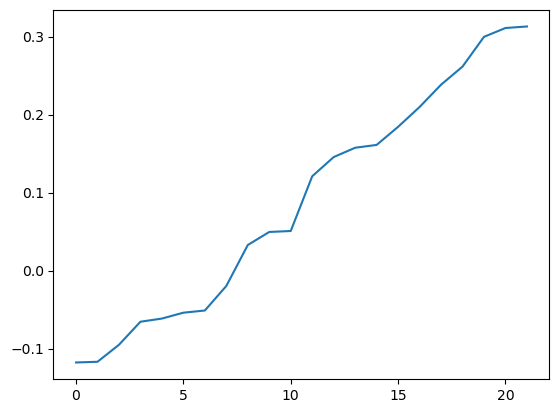

timestamp                  symbol
2022-09-23 22:00:00+00:00  ADA      -0.055556
                           ATOM     -0.055556
                           BTC       0.500000
                           DOT      -0.055556
                           ETC      -0.055556
                                       ...   
2022-11-22 22:00:00+00:00  ETH      -0.041187
                           LINK      0.174651
                           LTC       0.217210
                           MATIC     0.053001
                           XRP       0.055138
Name: position, Length: 14410, dtype: float32
['ADA', 'ATOM', 'BTC', 'DOT', 'ETC', 'ETH', 'LINK', 'LTC', 'MATIC', 'XRP']
test shift predict


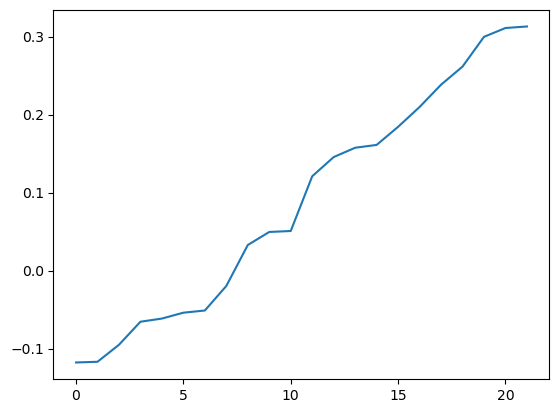

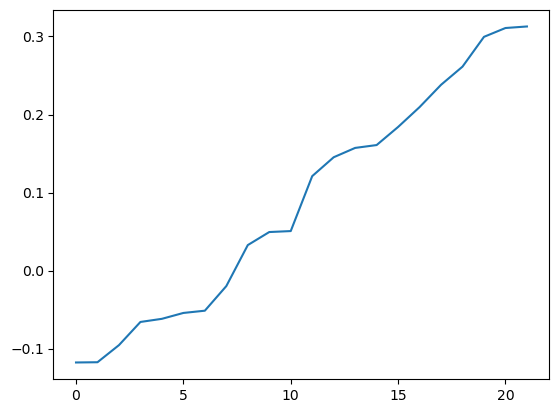

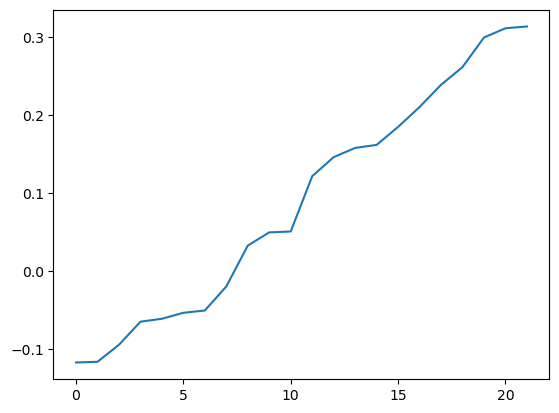

position1  position2  position3
timestamp                 symbol                                 
2022-09-23 23:00:00+00:00 ADA     -0.055556  -0.055556  -0.055556
                          ATOM    -0.055556  -0.055556  -0.055556
                          BTC      0.500000   0.500000   0.500000
                          DOT     -0.055556  -0.055556  -0.055556
                          ETC     -0.055556  -0.055556  -0.055556
...                                     ...        ...        ...
2022-11-22 21:00:00+00:00 ETH     -0.090628  -0.090628  -0.090628
                          LINK     0.168274   0.168274   0.168274
                          LTC      0.210537   0.210537   0.210537
                          MATIC    0.010067   0.010067   0.010067
                          XRP      0.007470   0.007470   0.007470

[14390 rows x 3 columns]

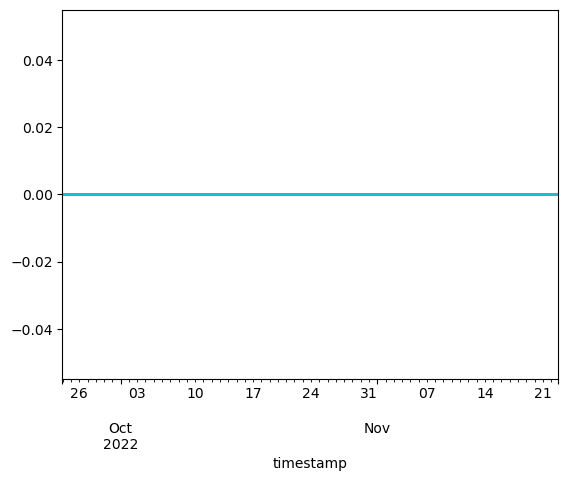

ADA (1439, 4)
ATOM (1439, 4)
BTC (1439, 4)
DOT (1439, 4)
ETC (1439, 4)
ETH (1439, 4)
LINK (1439, 4)
LTC (1439, 4)
MATIC (1439, 4)
XRP (1439, 4)


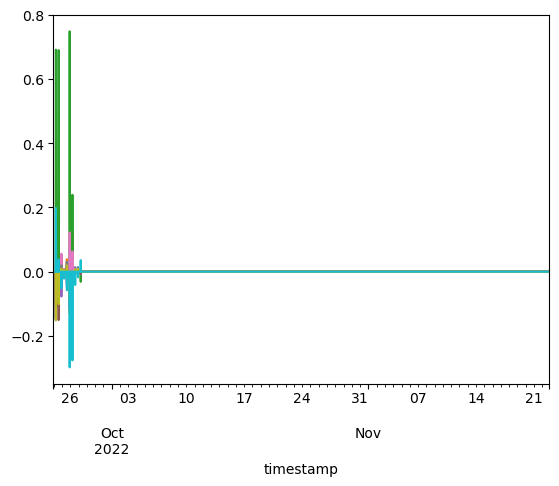

In [12]:
# model validation (Just run this cell in the new kernel to make sure you saved it in a portable format.)

import os
import joblib
import pandas as pd

model = joblib.load('/home/jovyan/data/{}.xz'.format(model_name))
df = pd.read_pickle('/tmp/df_binance_ohlcv_extended.pkl')
df = df[['op', 'hi', 'lo', 'cl', 'volume']]
max_timestamp = df.index.get_level_values('timestamp').max()
df = df.loc[max_timestamp - pd.to_timedelta(model.max_data_sec, unit='S') <= df.index.get_level_values('timestamp')]
print(model.predict(df))
print(model.symbols)



print('test shift predict')
import matplotlib.pyplot as plt

position1 = model.predict(df)
position2 = model.predict(df.loc[df.index.get_level_values('timestamp') < max_timestamp])
position3 = model.predict(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

test_timestamp = max_timestamp - pd.to_timedelta(1, unit='H')
df_test = pd.concat([
    position1.rename('position1'),
    position2.rename('position2'),
    position3.rename('position3'),
], axis=1)

df_test = df_test.dropna()
display(df_test)

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    (df_symbol['position2'] - df_symbol['position1']).plot()
plt.show()

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['position3'] - df_symbol['position1']).plot()
plt.show()